# Notebook 3: Model Development & Training

**Objective:** Design and train a deep learning model that predicts both drum onsets and velocities from mel spectrograms.

This notebook implements our drum transcription neural network architecture, loss functions, and training pipeline. The model has dual heads for both onset detection and velocity prediction, allowing it to capture not just when a drum is hit but also how hard it's played.

## 1. Imports and Setup

Loading required libraries for model development, training, and evaluation.

In [1]:
# This so the GPU doesnt crash
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import random
import os
import time
import sys
from sklearn.metrics import precision_recall_fscore_support


# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Paths
DATA_DIR = Path("../data")
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODEL_SAVE_DIR = Path("../models")
MODEL_SAVE_DIR.mkdir(exist_ok=True, parents=True)

# Drum mapping (same as in previous notebooks)
GM_DRUM_MAPPING = {
        36: "Kick",
        38: "Snare",
        42: "HiHat",
        47: "Tom",
        49: "Crash",
        51: "Ride"
    }

# Drum types constants
MAIN_DRUMS = list(GM_DRUM_MAPPING.keys())
MAIN_DRUM_NAMES = list(GM_DRUM_MAPPING.values())
N_DRUMS = len(MAIN_DRUMS)

# Configure plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["figure.figsize"] = (12, 8)
sns.set_theme(style="whitegrid")

def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses, f1_scores,
                    best_val_f1, patience_counter, filename):
    """Save a complete checkpoint that can be used to resume training."""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'f1_scores': f1_scores,
        'best_val_f1': best_val_f1,
        'patience_counter': patience_counter,
        # Store model config for easy reloading later (optional but recommended)
        'model_config': {
            'n_mels': model.n_mels,
            'n_drums': model.n_drums,
            'use_lstm': model.use_lstm,
            'lstm_hidden_size': model.lstm.hidden_size if model.use_lstm else None,
            'dropout': model.dropout_rate # Assuming you stored dropout rate in model
        }
    }, filename)
    print(f"Checkpoint saved to {filename}")

def load_checkpoint(filename, model, optimizer, scheduler=None):
    """Load a checkpoint to resume training."""
    filepath = Path(filename)
    if not filepath.exists():
        print(f"Checkpoint {filename} not found. Starting from scratch.")
        # Return defaults, ensuring best_val_f1 starts low for maximization
        return 0, [], [], [], -1.0, 0

    print(f"Loading checkpoint from {filename}")
    checkpoint = torch.load(filepath, map_location=device)

    # Load model state - check compatibility if needed
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    if scheduler and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict'] is not None:
         try:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
         except Exception as e:
             print(f"Warning: Could not load scheduler state dict: {e}. Scheduler may restart.")


    start_epoch = checkpoint.get('epoch', -1) + 1 # Resume from next epoch
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    f1_scores = checkpoint.get('f1_scores', [])
    # Load best_val_f1, default to -1.0 if not found (for maximization)
    best_val_f1 = checkpoint.get('best_val_f1', -1.0)
    patience_counter = checkpoint.get('patience_counter', 0)

    print(f"Resuming from epoch {start_epoch}. Best Valid F1 so far: {best_val_f1:.4f}")

    return start_epoch, train_losses, val_losses, f1_scores, best_val_f1, patience_counter

Using device: cuda


## 2. Create Dataset and DataLoader

Loading our preprocessed training examples (.npz files) and setting up the PyTorch data pipeline.

In [3]:
def create_small_dataset(data_dir, split, max_files=20):
    """Create a small toy dataset for testing the pipeline."""
    full_dir = Path(data_dir) / split
    all_files = list(full_dir.glob("*.npz"))

    print(f"Found {len(all_files)} total files for {split}")
    if len(all_files) <= max_files:
        return all_files

    # Take a random sample of files
    sampled_files = random.sample(all_files, max_files)
    print(f"Sampled {len(sampled_files)} files for {split} toy dataset")
    return sampled_files

class DrumTranscriptionDataset(Dataset):
    """Dataset for loading preprocessed drum transcription examples."""

    def __init__(self, data_dir, split="train", toy_mode=False, max_files=20):
        """
        Initialize the dataset.

        Args:
            data_dir: Directory containing the processed data
            split: Which dataset split to use ('train', 'validation', or 'test')
            toy_mode: If True, use only a small subset of files
            max_files: Maximum number of files to use in toy mode
        """
        self.data_dir = Path(data_dir) / split

        #
        self.use_checkpoint = True

        if toy_mode:
            self.file_list = create_small_dataset(data_dir, split, max_files)
        else:
            self.file_list = list(self.data_dir.glob("*.npz"))

        if len(self.file_list) == 0:
            raise ValueError(f"No .npz files found in {self.data_dir}")

        print(f"Using {len(self.file_list)} examples in {split} set")

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Load the NPZ file
        data = np.load(self.file_list[idx])

        # Extract features and targets
        mel_spec = data["mel_spec"].astype(np.float32)  # [n_mels, n_frames]
        onset_target = data["onset_target"].astype(np.float32)  # [n_drums, n_frames]
        velocity_target = data["velocity_target"].astype(np.float32)  # [n_drums, n_frames]

        # Add normalization to ensure inputs are scaled properly
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-8)

        # Convert to tensors
        mel_spec = torch.from_numpy(mel_spec)
        onset_target = torch.from_numpy(onset_target)
        velocity_target = torch.from_numpy(velocity_target)

        return {
            "input": mel_spec,
            "onset_target": onset_target,
            "velocity_target": velocity_target,
            "file_path": str(self.file_list[idx])
        }

def collate_fn(batch):
    """
    Custom collate function to handle variable-length sequences.
    Pads sequences to the maximum length in the batch.
    """
    # Get max sequence length in this batch
    max_frames = max(item["input"].shape[1] for item in batch)

    # Initialize tensors for batched data
    batch_size = len(batch)
    n_mels = batch[0]["input"].shape[0]
    n_drums = batch[0]["onset_target"].shape[0]

    # Create padded tensors
    inputs = torch.zeros((batch_size, n_mels, max_frames))
    onset_targets = torch.zeros((batch_size, n_drums, max_frames))
    velocity_targets = torch.zeros((batch_size, n_drums, max_frames))
    file_paths = []

    # Fill in the data
    for i, item in enumerate(batch):
        frames = item["input"].shape[1]
        inputs[i, :, :frames] = item["input"]
        onset_targets[i, :, :frames] = item["onset_target"]
        velocity_targets[i, :, :frames] = item["velocity_target"]
        file_paths.append(item["file_path"])

    return {
        "input": inputs,
        "onset_target": onset_targets,
        "velocity_target": velocity_targets,
        "file_paths": file_paths
    }


In [4]:
# Create datasets
train_dataset = DrumTranscriptionDataset(PROCESSED_DATA_DIR, split="train")
val_dataset = DrumTranscriptionDataset(PROCESSED_DATA_DIR, split="validation")
test_dataset = DrumTranscriptionDataset(PROCESSED_DATA_DIR, split="test")

# Create dataloaders
batch_size = 1
num_workers = 4
pin_memory = False
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

Using 3187 examples in train set
Using 683 examples in validation set
Using 684 examples in test set


### 2.1 Inspect a Batch

Let's examine a batch of data to understand the input and target formats.

Input shape: torch.Size([1, 229, 216])
Onset target shape: torch.Size([1, 6, 216])
Velocity target shape: torch.Size([1, 6, 216])


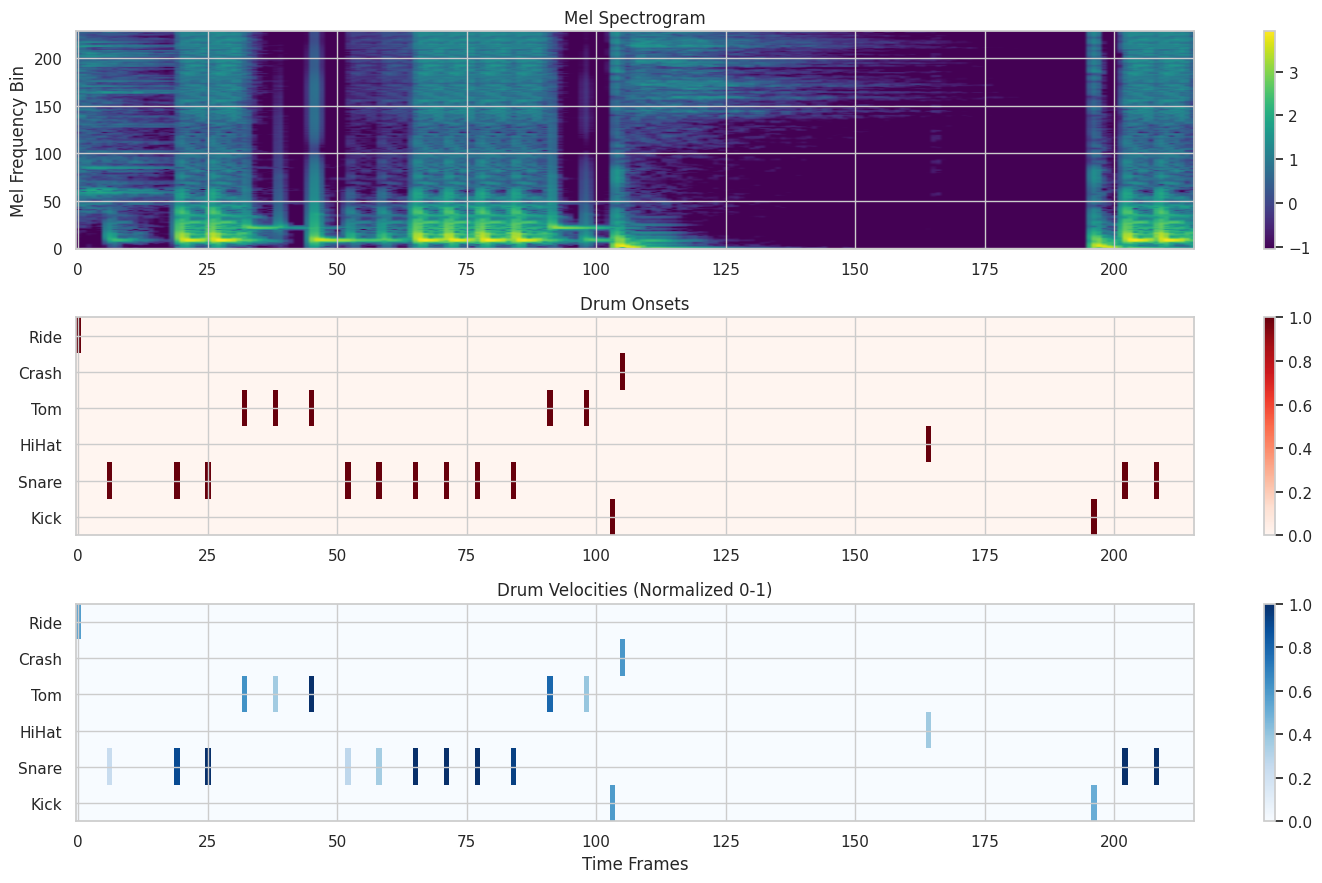

In [5]:
# Get a batch from the training loader
for batch in train_loader:
    inputs = batch["input"]
    onset_targets = batch["onset_target"]
    velocity_targets = batch["velocity_target"]

    print(f"Input shape: {inputs.shape}")  # [batch_size, n_mels, n_frames]
    print(f"Onset target shape: {onset_targets.shape}")  # [batch_size, n_drums, n_frames]
    print(f"Velocity target shape: {velocity_targets.shape}")  # [batch_size, n_drums, n_frames]

    # Plot one example
    idx = 0  # First example in batch
    plt.figure(figsize=(15, 9))

    # Plot mel spectrogram
    plt.subplot(3, 1, 1)
    plt.imshow(inputs[idx].numpy(), aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title('Mel Spectrogram')
    plt.ylabel('Mel Frequency Bin')

    # Plot onset targets
    plt.subplot(3, 1, 2)
    plt.imshow(onset_targets[idx].numpy(), aspect='auto', origin='lower', cmap='Reds')
    plt.colorbar()
    plt.title('Drum Onsets')
    plt.yticks(np.arange(N_DRUMS), MAIN_DRUM_NAMES)

    # Plot velocity targets
    plt.subplot(3, 1, 3)
    plt.imshow(velocity_targets[idx].numpy(), aspect='auto', origin='lower', cmap='Blues')
    plt.colorbar()
    plt.title('Drum Velocities (Normalized 0-1)')
    plt.yticks(np.arange(N_DRUMS), MAIN_DRUM_NAMES)
    plt.xlabel('Time Frames')

    plt.tight_layout()
    plt.show()

    # Just examine one batch
    break

## 3. Define Model Architecture

Create our drum transcription model based on a CNN architecture with dual output heads.

In [6]:
class ConvBlock(nn.Module):
    """Convolutional block with batch normalization and ReLU activation."""

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class DrumTranscriptionModel(nn.Module):
    """CNN model for drum transcription with dual output heads."""

    def __init__(self, n_mels=229, n_drums=6, use_lstm=True, lstm_hidden_size=256, dropout=0.3):
        """
        Initialize the model.

        Args:
            n_mels: Number of mel frequency bands in input
            n_drums: Number of drum types to detect
            use_lstm: Whether to use LSTM layers for temporal modeling
        """
        super(DrumTranscriptionModel, self).__init__()
        self.n_mels = n_mels
        self.n_drums = n_drums
        self.use_lstm = use_lstm
        self.dropout_rate = dropout

        # Feature extraction: convolutional layers
        self.conv_stack = nn.Sequential(
            # Layer 1: [B, 1, n_mels, T] -> [B, 32, n_mels//2, T]
            ConvBlock(1, 32),
            nn.MaxPool2d(kernel_size=(2, 1)),  # Frequency pooling

            # Layer 2: [B, 32, n_mels//2, T] -> [B, 64, n_mels//4, T]
            ConvBlock(32, 64),
            nn.MaxPool2d(kernel_size=(2, 1)),  # Frequency pooling

            # Layer 3: [B, 64, n_mels//4, T] -> [B, 128, n_mels//8, T]
            ConvBlock(64, 128),
            nn.MaxPool2d(kernel_size=(2, 1)),  # Frequency pooling

            # Layer 4: [B, 128, n_mels//8, T] -> [B, 128, n_mels//16, T]
            ConvBlock(128, 128),
            nn.MaxPool2d(kernel_size=(2, 1))   # Frequency pooling
        )

        # Calculate feature dimensions after CNN
        self.cnn_output_freq_dim = n_mels // 16
        self.cnn_output_channels = 128
        self.cnn_output_dim = self.cnn_output_channels * self.cnn_output_freq_dim

        # Optional: Bi-directional LSTM layer for temporal modeling
        if self.use_lstm:
            self.lstm = nn.LSTM(
                input_size=self.cnn_output_dim,
                hidden_size=lstm_hidden_size,
                num_layers=1,  # Could also make num_layers but idk
                batch_first=True,
                bidirectional=True,
                # Pass 0 dropout to LSTM if num_layers=1 to avoid warning
                dropout=0
            )
            # Apply dropout after LSTM if specified and num_layers is 1
            self.lstm_dropout = nn.Dropout(
                self.dropout_rate) if self.dropout_rate > 0 else nn.Identity()
            # bidirectional LSTM output (2 * hidden_size)
            feature_dim = lstm_hidden_size * 2
        else:
            feature_dim = self.cnn_output_dim
            self.lstm = None
            self.lstm_dropout = nn.Identity()

        # Onset detection head
        self.onset_head = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(128, n_drums),
            # Using logits
        )

        self.velocity_head = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(128, n_drums),
            nn.ReLU()
        )

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x: Input tensor of shape [batch_size, n_mels, n_frames]

        Returns:
            Tuple of (onset_predictions, velocity_predictions)
        """
        batch_size, n_mels, n_frames = x.shape
        x = x.unsqueeze(1)  # [B, 1, n_mels, T]

        # CNN forward
        x = self.conv_stack(x)  # [B, C, n_mels_reduced, T]

        # Reshape for RNN/Linear
        x = x.permute(0, 3, 1, 2)  # [B, T, C, n_mels_reduced]
        # Combine channel and frequency dims
        # [B, T, C * n_mels_reduced]
        x = x.reshape(batch_size, n_frames, self.cnn_output_dim)

        # Optional LSTM forward
        if self.use_lstm:
            x, _ = self.lstm(x)  # [B, T, 2 * hidden_size]
            x = self.lstm_dropout(x)  # Apply dropout

        # Output heads forward
        onset_logits = self.onset_head(x)  # [B, T, n_drums] - Logits
        # [B, T, n_drums] - Velocities >= 0
        velocity_pred = self.velocity_head(x)

        # Reshape to match target format [B, n_drums, T]
        onset_logits = onset_logits.transpose(1, 2)
        velocity_pred = velocity_pred.transpose(1, 2)

        # onset_logits are the raw outputs before sigmoid
        # velocity_pred are the predicted velocities (>= 0 due to final ReLU)
        return onset_logits, velocity_pred

## 4. Define Loss Functions

We'll define a combined loss function that handles both onset detection (binary cross entropy) and velocity prediction (mean squared error).

In [7]:
def combined_loss_function(
    onset_logits,
    velocity_pred,
    onset_target,
    velocity_target,
    onset_weight=0.8,
    positive_weight=10.0
):
    """
    Combined loss for both onset detection and velocity prediction.

    Args:
        onset_pred: Onset predictions [B, n_drums, T]
        velocity_pred: Velocity predictions [B, n_drums, T]
        onset_target: Onset targets [B, n_drums, T]
        velocity_target: Velocity targets [B, n_drums, T]
        onset_weight: Weight for onset loss (velocity_weight = 1 - onset_weight)

    Returns:
        Tuple of (combined_loss, onset_loss, velocity_loss)
    """
    onset_target = onset_target.float()
    # Create weight tensor with high values for positive examples
    weights = torch.ones_like(onset_target, device=onset_logits.device)
    weights[onset_target > 0.5] = positive_weight

    # Use binary_cross_entropy_with_logits instead of binary_cross_entropy
    onset_loss = F.binary_cross_entropy_with_logits(
        onset_logits,
        onset_target,
        weight=weights
    )

    mask = onset_target > 0.5
    if mask.sum() > 0:
        velocity_loss = F.mse_loss(velocity_pred[mask], velocity_target.float()[mask])
    else:
        velocity_loss = torch.tensor(0.0, device=onset_logits.device, dtype=torch.float32)

    velocity_weight = 1.0 - onset_weight
    combined = onset_weight * onset_loss + velocity_weight * velocity_loss

    return combined, onset_loss, velocity_loss

## 5. Training Loop

Define functions to train the model and evaluate it on validation data.

In [14]:
def train_epoch(model, train_loader, optimizer, device, onset_weight=0.8, positive_weight=10.0, scaler=None, accum_steps=4):
    """Train the model for one epoch with gradient accumulation and mixed precision."""
    model.train()
    epoch_loss = 0
    epoch_onset_loss = 0
    epoch_velocity_loss = 0
    processed_samples = 0

    optimizer.zero_grad()
    progress_bar = tqdm(train_loader, desc="Training")
    for i, batch in enumerate(progress_bar):
        # Move data to device
        inputs = batch["input"].to(device)
        onset_target = batch["onset_target"].to(device)
        velocity_target = batch["velocity_target"].to(device)
        batch_size = inputs.size(0)

        # Forward pass with mixed precision
        with torch.amp.autocast(device_type='cuda', enabled=scaler is not None):
            # Model output are logits and velocity predictions
            onset_logits, velocity_pred = model(inputs)

            # Loss calculation uses logits directly
            loss, onset_loss_val, velocity_loss_val = combined_loss_function(
                onset_logits, velocity_pred, onset_target, velocity_target,
                onset_weight=onset_weight,
                positive_weight=positive_weight
            )

            # Scale the loss by accumulation steps
            loss = loss / accum_steps

        if scaler:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        # Only update weights after accumulating gradients for accum_steps batches
        if (i + 1) % accum_steps == 0 or (i + 1) == len(train_loader):
            if scaler:
                # Unscale before optimizer step (helps with gradient clipping if used)
                scaler.unscale_(optimizer)
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Example clipping
                # Update weights with scaling aware step
                scaler.step(optimizer)

                # Update the scaler
                scaler.update()
            else:
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Example clipping
                optimizer.step()

            # Zero gradients for next batch
            optimizer.zero_grad()

        # Log unscaled loss values per sample
        epoch_loss += loss.item() * accum_steps * batch_size  # total loss for the batch
        epoch_onset_loss += onset_loss_val.item() * batch_size
        epoch_velocity_loss += velocity_loss_val.item() * batch_size
        processed_samples += batch_size

        progress_bar.set_postfix({
            'loss': f"{loss.item() * accum_steps:.4f}",  # Batch avg loss
            'ons_loss': f"{onset_loss_val.item():.4f}",
            'vel_loss': f"{velocity_loss_val.item():.4f}"
        })

    # Return average loss per sample for the epoch
    return {
        'loss': epoch_loss / processed_samples,
        'onset_loss': epoch_onset_loss / processed_samples,
        'velocity_loss': epoch_velocity_loss / processed_samples
    }


def validate(model, val_loader, device, onset_weight=0.8, positive_weight=10.0, fixed_threshold=None):
    """
    Evaluate the model on validation data.
    Optimizes the detection threshold based on **Macro F1 Score**.

    Args:
        model: The model to evaluate.
        val_loader: DataLoader for validation data.
        device: Device to run on (CPU or GPU).
        onset_weight: Weight for onset loss component.
        positive_weight: Weight for positive examples in BCE loss.
        fixed_threshold: If provided, use this threshold instead of optimizing.

    Returns:
        Dictionary of metrics including the optimized threshold.
    """
    model.eval()
    val_loss = 0
    val_onset_loss = 0
    val_velocity_loss = 0
    processed_samples = 0

    # Lists to store predictions and targets across all batches for metric calculation
    all_onset_probs_flat = []
    all_onset_targets_flat = []


    all_drum_probs = {i: [] for i in range(model.n_drums)}
    all_drum_targets = {i: [] for i in range(model.n_drums)}

    with torch.no_grad():
        # leave=False if inside another loop
        progress_bar = tqdm(val_loader, desc="Validating", leave=False)
        for batch in progress_bar:
            # Move data to the computation device
            inputs = batch["input"].to(device)
            onset_target = batch["onset_target"].to(device)
            velocity_target = batch["velocity_target"].to(device)
            batch_size = inputs.size(0)

            # Get model predictions (logits and velocities)
            onset_logits, velocity_pred = model(inputs)

            # --- Calculate Loss ---
            # Loss calculation uses the raw logits
            loss, onset_loss_val, velocity_loss_val = combined_loss_function(
                onset_logits, velocity_pred, onset_target, velocity_target,
                onset_weight=onset_weight,
                positive_weight=positive_weight
            )

            # Accumulate batch losses weighted by batch size
            val_loss += loss.item() * batch_size
            val_onset_loss += onset_loss_val.item() * batch_size
            val_velocity_loss += velocity_loss_val.item() * batch_size
            processed_samples += batch_size

            # --- Prepare Data for Metric Calculation ---
            # Convert logits to probabilities [0, 1] for thresholding
            onset_probs = torch.sigmoid(onset_logits)

            # Move predictions and targets to CPU and convert to NumPy arrays
            onset_probs_np = onset_probs.detach().cpu().numpy()
            onset_target_np = onset_target.detach().cpu().numpy()

            # Flatten the arrays (batch, drums, time -> one long dimension)
            # This is needed for sklearn metrics when calculating overall scores
            all_onset_probs_flat.append(onset_probs_np.reshape(-1))
            all_onset_targets_flat.append(onset_target_np.reshape(-1))

            # Optionally store per-drum if needed later (commented out for brevity)
            for i in range(model.n_drums):
                all_drum_probs[i].extend(onset_probs_np[:, i, :].flatten())
                all_drum_targets[i].extend(onset_target_np[:, i, :].flatten())

            # Update progress bar postfix with running average loss
            if processed_samples > 0:
                progress_bar.set_postfix({
                    'val_loss': f"{val_loss / processed_samples:.4f}",
                    'ons_loss': f"{val_onset_loss / processed_samples:.4f}",
                    'vel_loss': f"{val_velocity_loss / processed_samples:.4f}"
                })

    # --- Handle Empty Loader Case ---
    if processed_samples == 0:
        print("Warning: Validation loader was empty. Returning default metrics.")

        return {
            'loss': float('nan'), 'onset_loss': float('nan'), 'velocity_loss': float('nan'),
            'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'macro_f1': 0.0,
            'threshold': fixed_threshold if fixed_threshold is not None else 0.5,
            'drum_metrics': {name: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0} for name in MAIN_DRUM_NAMES}
        }

    # --- Concatenate predictions/targets from all batches ---
    all_preds_flat = np.concatenate(all_onset_probs_flat)
    all_targets_flat = np.concatenate(all_onset_targets_flat)

    # --- Threshold Optimization (Based on Macro F1) ---
    if fixed_threshold is not None:
        best_threshold = fixed_threshold
        print(f"Using fixed threshold: {best_threshold:.2f}")
    else:
        best_macro_f1 = -1.0  # Track the best Macro F1 found
        best_threshold = 0.5  # Default starting point
        print(f"Optimizing threshold for Macro F1 score...")

        # Iterate through candidate thresholds
        threshold_range = np.arange(0.1, 0.9, 0.05)
        for threshold in threshold_range:
            # Apply current threshold
            binary_preds = (all_preds_flat > threshold).astype(int)

            # *** Calculate Macro F1 for this threshold ***
            # Note: P/R returned here are also macro-averaged, but we only need F1 for optimization
            _, _, current_macro_f1, _ = precision_recall_fscore_support(
                all_targets_flat, binary_preds, average='macro', zero_division=0
            )

            # *** Update best threshold if current Macro F1 is better ***
            if current_macro_f1 > best_macro_f1:
                best_macro_f1 = current_macro_f1
                best_threshold = threshold

        print(
            f"Optimal threshold found: {best_threshold:.2f} (yielding best Macro F1: {best_macro_f1:.4f})")

    # --- Calculate Final Metrics using the Determined Best Threshold ---
    print(f"Calculating final metrics using threshold = {best_threshold:.2f}")
    final_binary_preds = (all_preds_flat > best_threshold).astype(int)

    # Calculate final Binary Precision, Recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets_flat, final_binary_preds, average='binary', zero_division=0
    )
    # Calculate final Macro Precision, Recall, F1
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        all_targets_flat, final_binary_preds, average='macro', zero_division=0
    )

    # --- Calculate Per-Drum Metrics (using the same best_threshold) ---
    # This still uses binary F1 per drum, which is standard practice here
    drum_metrics = {}
    # Define MAIN_DRUM_NAMES if not global or ensure it's passed/accessible
    for i, drum_name in enumerate(MAIN_DRUM_NAMES):
        if i < model.n_drums:
            drum_preds_np = np.array(all_drum_probs[i])
            drum_targets_np = np.array(all_drum_targets[i])
            binary_preds = (drum_preds_np > best_threshold).astype(int)
            p, r, f, _ = precision_recall_fscore_support(
                drum_targets_np, binary_preds, average='binary', zero_division=0
            )
            drum_metrics[drum_name] = {'precision': p, 'recall': r, 'f1': f}

        else:
            print(
                f"Warning: Drum index {i} out of range for model n_drums={model.n_drums}")

    # --- Return Results ---
    # Calculate average losses per sample
    avg_loss = val_loss / processed_samples
    avg_onset_loss = val_onset_loss / processed_samples
    avg_velocity_loss = val_velocity_loss / processed_samples

    return {
        'loss': avg_loss,
        'onset_loss': avg_onset_loss,
        'velocity_loss': avg_velocity_loss,
        'precision': precision,             # Final Binary Precision
        'recall': recall,                   # Final Binary Recall
        'f1': f1,                           # Final Binary F1
        'macro_precision': macro_precision, # Final Macro Precision
        'macro_recall': macro_recall,       # Final Macro Recall
        'macro_f1': macro_f1,               # Final Macro F1
        'threshold': best_threshold,        # Threshold optimized for Macro F1
        # Per-drum metrics (currently empty placeholder)
        'drum_metrics': drum_metrics
    }


def train_model(model, train_loader, val_loader, device,
                learning_rate=0.001, epochs=30, patience=5,
                onset_weight=0.8, positive_weight=10.0,
                resume_from=None, accum_steps=8):
    """
    Train the model with early stopping, learning rate scheduling (based on Val F1),
    and checkpointing (saving best model based on Val F1).
    """

    print(f"\n--- Starting Training ---")
    print(f"Device: {device}")
    print(f"Learning Rate: {learning_rate}")
    print(f"Epochs: {epochs}, Patience: {patience}")
    print(f"Onset Weight: {onset_weight}, Positive Weight: {positive_weight}")
    print(f"Accumulation Steps: {accum_steps}")
    print(f"Model Config: use_lstm={model.use_lstm}, dropout={model.dropout_rate}" +
          (f", lstm_hidden={model.lstm.hidden_size}" if model.use_lstm else ""))

    # Initialize optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(), lr=learning_rate, weight_decay=1e-5)
    # Scheduler monitors Validation F1 Score (maximize)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',      # Maximize F1
        factor=0.5,
        patience=3,      # Scheduler patience (e.g., reduce LR if F1 stagnates for 3 epochs)
    )

    # Mixed precision scaler
    scaler = torch.amp.GradScaler(
        device.type) if device.type == 'cuda' else None

    # Track metrics - Initialize best_val_f1 low for maximization
    best_val_f1 = -1.0
    patience_counter = 0  # For early stopping
    train_losses = []
    val_losses = []
    f1_scores = []
    start_epoch = 0

    # Checkpoint setup
    checkpoint_dir = MODEL_SAVE_DIR / 'checkpoints'
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    # Path for the best model overall
    best_model_path = MODEL_SAVE_DIR / 'drum_transcription_best.pt'

    # Resume training if a checkpoint is provided
    # Use the updated load_checkpoint which handles best_val_f1
    if resume_from:
        latest_checkpoint_path = checkpoint_dir / "checkpoint_latest.pt"
        if Path(latest_checkpoint_path).exists():
            start_epoch, train_losses, val_losses, f1_scores, best_val_f1, patience_counter = load_checkpoint(
                latest_checkpoint_path, model, optimizer, scheduler
            )
        else:
            print(
                f"Latest checkpoint {latest_checkpoint_path} not found, starting fresh.")

    # --- Main Training Loop ---
    for epoch in range(start_epoch, epochs):
        print(
            f"\nEpoch {epoch+1}/{epochs} | LR: {optimizer.param_groups[0]['lr']:.1e}")
        start_time = time.time()

        # --- Train ---
        model.train()  # Set model to training mode
        # Pass positive_weight to train_epoch
        train_metrics = train_epoch(
            model, train_loader, optimizer, device,
            onset_weight=onset_weight,
            positive_weight=positive_weight,
            scaler=scaler,
            accum_steps=accum_steps
        )
        train_loss = train_metrics['loss']
        train_losses.append(train_loss)

        # --- Validate ---
        model.eval()  # Set model to evaluation mode
        # Pass positive_weight to validate
        val_metrics = validate(
            model, val_loader, device,
            onset_weight=onset_weight,
            positive_weight=positive_weight
        )
        val_loss = val_metrics['loss']

        # Changed to macro to take into account all drums
        current_val_f1 = val_metrics.get(
            'macro_f1', 0.0)  # Alternative: Use macro F1

        val_losses.append(val_loss)
        f1_scores.append(current_val_f1)

        # --- Scheduler Step ---
        scheduler.step(current_val_f1)  # Step based on validation F1

        # --- Print Epoch Summary ---
        epoch_time = time.time() - start_time
        print(f"  Epoch Time: {epoch_time:.2f}s")
        print(
            f"  Train Loss: {train_loss:.4f} (Onset: {train_metrics['onset_loss']:.4f}, Vel: {train_metrics['velocity_loss']:.4f})")
        print(
            f"  Val Loss:   {val_loss:.4f} (Onset: {val_metrics['onset_loss']:.4f}, Vel: {val_metrics['velocity_loss']:.4f})")
        print(
            f"  Val F1:     {current_val_f1:.4f} (Thresh: {val_metrics['threshold']:.2f}, P: {val_metrics['precision']:.4f}, R: {val_metrics['recall']:.4f})")
        if 'macro_f1' in val_metrics:
            print(f"  Val Macro F1: {val_metrics['macro_f1']:.4f}")

        # --- Checkpointing & Early Stopping based on F1 Score ---
        # Save latest checkpoint regardless
        latest_path = checkpoint_dir / "checkpoint_latest.pt"
        # Use updated save_checkpoint which expects best_val_f1
        save_checkpoint(
            model, optimizer, scheduler, epoch, train_losses, val_losses,
            f1_scores, best_val_f1, patience_counter, latest_path
        )

        # Check for improvement in Validation F1
        if current_val_f1 > best_val_f1:
            best_val_f1 = current_val_f1  # Update best F1 score
            patience_counter = 0  # Reset patience
            print(f"  🏅 New best validation F1 found: {best_val_f1:.4f}")

            # Save the best model checkpoint based on F1
            # Include config used for this run in the checkpoint for reproducibility
            model_config_to_save = {
                'n_mels': model.n_mels, 'n_drums': model.n_drums, 'use_lstm': model.use_lstm,
                'lstm_hidden_size': model.lstm.hidden_size if model.use_lstm else None,
                'dropout': model.dropout_rate
            }
            training_params_to_save = {
                'learning_rate': learning_rate, 'onset_weight': onset_weight,
                'positive_weight': positive_weight, 'accum_steps': accum_steps
            }
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'model_config': model_config_to_save,
                'training_params': training_params_to_save,
                'train_loss': train_loss,  # Loss at this epoch
                'val_loss': val_loss,     # Loss at this epoch
                'val_f1': best_val_f1,    # The best F1 score achieved so far
                # Threshold corresponding to this F1
                'val_threshold': val_metrics['threshold']
            }, best_model_path)
            print(f"  💾 Saved best model checkpoint to {best_model_path}")

        else:
            patience_counter += 1
            print(
                f"  No improvement in validation F1 for {patience_counter}/{patience} epochs.")
            if patience_counter >= patience:
                print(f"\n🛑 Early stopping triggered after {epoch+1} epochs.")
                break  # Stop training

    print("\n--- Training Finished ---")

    # --- Plot History ---
    if train_losses and val_losses and f1_scores:  # Check if lists are not empty
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.ylim(bottom=0)  # Start y-axis at 0 for loss

        plt.subplot(1, 2, 2)
        plt.plot(f1_scores, label='Validation F1 Score', color='green')
        # Add best F1 line for context
        plt.axhline(y=best_val_f1, color='red', linestyle='--',
                    label=f'Best F1 ({best_val_f1:.4f})')
        plt.title('Validation F1 Score History')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)
        plt.ylim(0, 1)  # F1 score is between 0 and 1

        plt.tight_layout()
        plt.show()
    else:
        print("No data to plot training history.")

    return model, train_losses, val_losses, f1_scores  # Return model and histories

Visualization

In [9]:
def visualize_predictions(model, data_loader, device, threshold=0.5, num_samples=3):
    """Visualize model predictions on a few samples."""
    model.eval()

    samples_seen = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch["input"].to(device)
            onset_targets = batch["onset_target"]
            velocity_targets = batch["velocity_target"]
            file_paths = batch["file_paths"]

            # Forward pass
            onset_preds, velocity_preds = model(inputs)
            onset_preds = onset_preds.cpu()
            onset_probs = torch.sigmoid(onset_preds)
            velocity_preds = velocity_preds.cpu()

            # Loop through each item in the batch
            for i in range(min(inputs.size(0), num_samples - samples_seen)):
                # Get a single sample
                input_spec = inputs[i].cpu()
                onset_target = onset_targets[i]
                velocity_target = velocity_targets[i]
                onset_pred = onset_preds[i]
                velocity_pred = velocity_preds[i]

                # Create binary onset predictions - fix applied here
                binary_onset = (onset_probs[i] > threshold).float()

                # Create a mask for velocities based on predicted onsets
                masked_velocity_pred = velocity_pred * binary_onset

                # Visualize
                plt.figure(figsize=(15, 10))

                # Plot input spectrogram
                plt.subplot(4, 1, 1)
                plt.imshow(input_spec.numpy(), aspect='auto', origin='lower', cmap='viridis')
                plt.colorbar()
                plt.title('Mel Spectrogram')
                plt.ylabel('Mel Bin')

                # Plot ground truth onsets
                plt.subplot(4, 1, 2)
                plt.imshow(onset_target.numpy(), aspect='auto', origin='lower', cmap='Reds')
                plt.colorbar()
                plt.title('Ground Truth Onsets')
                plt.yticks(np.arange(N_DRUMS), MAIN_DRUM_NAMES)

                # Plot predicted onsets (binary)
                plt.subplot(4, 1, 3)
                plt.imshow(binary_onset.numpy(), aspect='auto', origin='lower', cmap='OrRd')
                plt.colorbar()
                plt.title(f'Predicted Onsets (threshold={threshold})')
                plt.yticks(np.arange(N_DRUMS), MAIN_DRUM_NAMES)

                # Plot predicted velocities (masked by onset predictions)
                plt.subplot(4, 1, 4)
                plt.imshow(masked_velocity_pred.numpy(), aspect='auto', origin='lower', cmap='Blues')
                plt.colorbar()
                plt.title('Predicted Velocities (only where onset predicted)')
                plt.yticks(np.arange(N_DRUMS), MAIN_DRUM_NAMES)
                plt.xlabel('Time Frame')

                plt.tight_layout()
                plt.show()

                # Show the file path of this example
                print(f"File: {file_paths[i]}")

                samples_seen += 1

            if samples_seen >= num_samples:
                break

## 6. Grid Search

using optuna

In [10]:
import optuna

def objective(trial, train_loader, val_loader, device, max_epochs_per_trial=15, accum_steps=1):
    """Objective function for Optuna HPO."""

    # --- 1. Suggest Hyperparameters ---
    # We define the search space here
    cfg = {}
    cfg['use_lstm'] = trial.suggest_categorical('use_lstm', [True, False])
    cfg['learning_rate'] = trial.suggest_float('learning_rate', 5e-4, 8e-3, log=True) # Wider range, log scale
    cfg['dropout'] = trial.suggest_float('dropout', 0.1, 0.5)
    cfg['onset_weight'] = trial.suggest_float('onset_weight', 0.6, 0.9)
    cfg['positive_weight'] = trial.suggest_float('positive_weight', 5.0, 30.0) # Wider range
    if cfg['use_lstm']:
        # Only suggest LSTM size if LSTM is used
        cfg['lstm_hidden_size'] = trial.suggest_categorical('lstm_hidden_size', [64, 128, 256, 512]) # Wider range
    else:
        cfg['lstm_hidden_size'] = 256 # Default placeholder, not used by model if use_lstm=False

    print(f"\n--- Optuna Trial {trial.number} ---")
    print(f"Config: {cfg}")

    # --- 2. Setup Model, Optimizer, Scaler ---
    model = DrumTranscriptionModel(
        n_mels=229, n_drums=N_DRUMS,
        use_lstm=cfg['use_lstm'],
        lstm_hidden_size=cfg['lstm_hidden_size'], # Pass the suggested size
        dropout=cfg['dropout']
    ).to(device)

    # Consider AdamW for potentially better generalization
    optimizer = optim.AdamW(model.parameters(), lr=cfg['learning_rate'], weight_decay=1e-5) # Added weight decay
    # Note: Could also tune weight_decay: trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)

    # Scheduler based on validation F1 score (maximize)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    scaler = torch.amp.GradScaler(device.type) if device.type == 'cuda' else None

    # --- 3. Training Loop with Pruning ---
    best_val_f1_trial = -1.0 # Track best F1 *within this trial*
    early_stopping_patience = 4 # Internal patience for the trial
    patience_counter = 0

    for epoch in range(max_epochs_per_trial):
        # Train one epoch
        train_metrics = train_epoch(
            model, train_loader, optimizer, device,
            onset_weight=cfg['onset_weight'],        # Use suggested value
            positive_weight=cfg['positive_weight'], # Use suggested value
            scaler=scaler,
            accum_steps=accum_steps                 # Use value passed to objective
        )
        # Validate
        val_metrics = validate(
             model, val_loader, device,
             onset_weight=cfg['onset_weight'],        # Use suggested value
             positive_weight=cfg['positive_weight']  # Use suggested value
        )

        # *** Use F1 score as the metric to optimize ***
        current_f1 = val_metrics['macro_f1'] # before it was f1

        print(f"  Epoch {epoch+1}/{max_epochs_per_trial}: Val F1: {current_f1:.4f}, Val Loss: {val_metrics['loss']:.4f}")

        # Update best F1 for this trial
        if current_f1 > best_val_f1_trial:
             best_val_f1_trial = current_f1
             patience_counter = 0
        else:
             patience_counter += 1

        # Step the scheduler based on F1 score
        scheduler.step(current_f1)

        # --- Optuna Reporting/Pruning ---
        trial.report(current_f1, epoch) # Report the F1 score at this epoch
        if trial.should_prune():
            print(f"  Trial {trial.number} pruned at epoch {epoch+1}")
            # Return the best F1 achieved *before* pruning
            return best_val_f1_trial

        # Internal early stopping for the trial
        if patience_counter >= early_stopping_patience:
             print(f"  Trial {trial.number} stopped early at epoch {epoch+1} due to internal patience.")
             break

    # Clean up GPU memory after trial
    del model
    if device.type == 'cuda':
        torch.cuda.empty_cache()

    # --- 4. Return Final Metric for Optuna ---
    # Return the best validation F1 score achieved during this trial
    return best_val_f1_trial

In [11]:
toy_train_dataset = DrumTranscriptionDataset(PROCESSED_DATA_DIR, split="train", toy_mode=True, max_files=250)
toy_val_dataset = DrumTranscriptionDataset(PROCESSED_DATA_DIR, split="validation", toy_mode=True, max_files=250)

# Create toy dataloaders
toy_batch_size = 1 # With more it goes CUDA out of memory..............
toy_train_loader = DataLoader(
    toy_train_dataset,
    batch_size=toy_batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=1,
    pin_memory=False
)

toy_val_loader = DataLoader(
    toy_val_dataset,
    batch_size=toy_batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
    pin_memory=False
)

print(f"Toy train samples: {len(toy_train_dataset)}, Toy val samples: {len(toy_val_dataset)}")


Found 3187 total files for train
Sampled 250 files for train toy dataset
Using 250 examples in train set
Found 683 total files for validation
Sampled 250 files for validation toy dataset
Using 250 examples in validation set
Toy train samples: 250, Toy val samples: 250


In [12]:
import optuna

# --- Define Optuna Study Parameters ---
N_TRIALS = 50 # Total number of trials desired for the study
EPOCHS_PER_TRIAL = 15 # Max epochs for each individual trial
ACCUM_STEPS_SEARCH = 1

# --- Define Storage for Resumability ---
study_name = "drum_transcription_hpo_v1"
db_filename = f"{study_name}.db"
study_db_path = f"sqlite:///{MODEL_SAVE_DIR / db_filename}"
print(f"Optuna study storage path: {study_db_path}")

# --- Create or Load the Optuna Study ---
study = optuna.create_study(
    study_name=study_name,
    storage=study_db_path,    # Use SQLite storage
    load_if_exists=True,      # Load if study with this name exists in the storage
    direction='maximize',     # We want to maximize the F1 score returned by 'objective'
    pruner=optuna.pruners.MedianPruner( # Pruner stops unpromising trials early
        n_startup_trials=5,  # Run at least 5 trials before pruning starts
        n_warmup_steps=4,    # Run at least 4 epochs within a trial before pruning
        interval_steps=1     # Check for pruning every epoch after warmup
    )
)

# --- Calculate Remaining Trials ---
# Check how many trials have already been completed in the loaded study
completed_trials = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
total_trials_in_study = len(study.trials) # Includes running, pruned, failed etc.

print(f"\n--- Optuna Study Status ---")
print(f"Study Name: {study_name}")
print(f"Storage: {study_db_path}")
print(f"Direction: {study.direction}")
print(f"Total trials in study: {total_trials_in_study}")
print(f"Completed trials: {completed_trials}")

# Determine how many more trials are needed to reach the target N_TRIALS
n_trials_to_run = N_TRIALS - total_trials_in_study

# --- Run Optimization (if needed) ---
if n_trials_to_run > 0:
    print(f"\nStarting/Resuming Optuna search.")
    print(f"Target total trials: {N_TRIALS}")
    print(f"Running {n_trials_to_run} more trials (max {EPOCHS_PER_TRIAL} epochs each)...")

    # Pass the objective function and arguments to study.optimize
    # The lambda function is used to pass the extra arguments required by our objective function
    study.optimize(
        lambda trial: objective( # Define the objective function call within lambda
            trial,
            toy_train_loader,  # Make sure toy_train_loader is defined and accessible
            toy_val_loader,    # Make sure toy_val_loader is defined and accessible
            device,            # Make sure device is defined and accessible
            max_epochs_per_trial=EPOCHS_PER_TRIAL,
            accum_steps=ACCUM_STEPS_SEARCH
        ),
        n_trials=n_trials_to_run, # Run only the remaining number of trials
        gc_after_trial=True,      # Enable garbage collection after each trial to free memory
        show_progress_bar=True    # Display a progress bar for the trials
    )
    print(f"\nFinished running {n_trials_to_run} trials.")
else:
    print(f"\nOptuna search previously completed. Target of {N_TRIALS} trials reached.")

# --- Display Results ---
print("\n--- Optuna Search Complete ---")

# Check if any successful trials exist before accessing best_trial
if study.best_trial:
    print(f"Best trial number: {study.best_trial.number}")

    print(f"Best Validation F1 score: {study.best_value:.4f}")
    print("Best hyperparameters found:")
    best_params = study.best_params # Get the dictionary of best parameters
    print(best_params)

    # --- Save the Results DataFrame ---
    try:
        study_results_df = study.trials_dataframe()
        # Use the study name in the CSV filename for clarity
        results_csv_path = MODEL_SAVE_DIR / f"{study_name}_results.csv"
        study_results_df.to_csv(results_csv_path, index=False)
        print(f"\nOptuna study results saved to {results_csv_path}")
    except Exception as e:
        print(f"\nError saving Optuna results dataframe: {e}")

else:
    print("No successful trials were completed in the study. Cannot determine best parameters.")
    best_params = {}


Optuna study storage path: sqlite:///../models/drum_transcription_hpo_v1.db


[I 2025-05-04 10:37:42,153] A new study created in RDB with name: drum_transcription_hpo_v1



--- Optuna Study Status ---
Study Name: drum_transcription_hpo_v1
Storage: sqlite:///../models/drum_transcription_hpo_v1.db
Direction: 2
Total trials in study: 0
Completed trials: 0

Starting/Resuming Optuna search.
Target total trials: 50
Running 50 more trials (max 15 epochs each)...


  0%|          | 0/50 [00:00<?, ?it/s]


--- Optuna Trial 0 ---
Config: {'use_lstm': False, 'learning_rate': 0.002103165561450347, 'dropout': 0.304906185077483, 'onset_weight': 0.6724888730307069, 'positive_weight': 5.27936653776793, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.45 (yielding best Macro F1: 0.6226)
Calculating final metrics using threshold = 0.45
  Epoch 1/15: Val F1: 0.6226, Val Loss: 0.2189


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.6695)
Calculating final metrics using threshold = 0.50
  Epoch 2/15: Val F1: 0.6695, Val Loss: 0.1807


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.45 (yielding best Macro F1: 0.6807)
Calculating final metrics using threshold = 0.45
  Epoch 3/15: Val F1: 0.6807, Val Loss: 0.1774


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6910)
Calculating final metrics using threshold = 0.55
  Epoch 4/15: Val F1: 0.6910, Val Loss: 0.1784


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6941)
Calculating final metrics using threshold = 0.55
  Epoch 5/15: Val F1: 0.6941, Val Loss: 0.1670


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6860)
Calculating final metrics using threshold = 0.65
  Epoch 6/15: Val F1: 0.6860, Val Loss: 0.1767


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7015)
Calculating final metrics using threshold = 0.55
  Epoch 7/15: Val F1: 0.7015, Val Loss: 0.1697


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.7018)
Calculating final metrics using threshold = 0.50
  Epoch 8/15: Val F1: 0.7018, Val Loss: 0.1638


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7071)
Calculating final metrics using threshold = 0.65
  Epoch 9/15: Val F1: 0.7071, Val Loss: 0.1593


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7095)
Calculating final metrics using threshold = 0.55
  Epoch 10/15: Val F1: 0.7095, Val Loss: 0.1549


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7096)
Calculating final metrics using threshold = 0.55
  Epoch 11/15: Val F1: 0.7096, Val Loss: 0.1582


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7100)
Calculating final metrics using threshold = 0.65
  Epoch 12/15: Val F1: 0.7100, Val Loss: 0.1621


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7077)
Calculating final metrics using threshold = 0.60
  Epoch 13/15: Val F1: 0.7077, Val Loss: 0.1588


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7146)
Calculating final metrics using threshold = 0.55
  Epoch 14/15: Val F1: 0.7146, Val Loss: 0.1571


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7111)
Calculating final metrics using threshold = 0.55
  Epoch 15/15: Val F1: 0.7111, Val Loss: 0.1594
[I 2025-05-04 10:40:07,874] Trial 0 finished with value: 0.7146325281085655 and parameters: {'use_lstm': False, 'learning_rate': 0.002103165561450347, 'dropout': 0.304906185077483, 'onset_weight': 0.6724888730307069, 'positive_weight': 5.27936653776793}. Best is trial 0 with value: 0.7146325281085655.

--- Optuna Trial 1 ---
Config: {'use_lstm': False, 'learning_rate': 0.0010753164677591172, 'dropout': 0.3187953208226538, 'onset_weight': 0.6213423928540847, 'positive_weight': 12.578569856401707, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6594)
Calculating final metrics using threshold = 0.75
  Epoch 1/15: Val F1: 0.6594, Val Loss: 0.3298


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6689)
Calculating final metrics using threshold = 0.75
  Epoch 2/15: Val F1: 0.6689, Val Loss: 0.3221


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6884)
Calculating final metrics using threshold = 0.70
  Epoch 3/15: Val F1: 0.6884, Val Loss: 0.3011


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6909)
Calculating final metrics using threshold = 0.65
  Epoch 4/15: Val F1: 0.6909, Val Loss: 0.2995


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6972)
Calculating final metrics using threshold = 0.70
  Epoch 5/15: Val F1: 0.6972, Val Loss: 0.2856


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.7002)
Calculating final metrics using threshold = 0.75
  Epoch 6/15: Val F1: 0.7002, Val Loss: 0.2561


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6985)
Calculating final metrics using threshold = 0.75
  Epoch 7/15: Val F1: 0.6985, Val Loss: 0.2633


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7025)
Calculating final metrics using threshold = 0.70
  Epoch 8/15: Val F1: 0.7025, Val Loss: 0.2478


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.7035)
Calculating final metrics using threshold = 0.75
  Epoch 9/15: Val F1: 0.7035, Val Loss: 0.2372


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7043)
Calculating final metrics using threshold = 0.70
  Epoch 10/15: Val F1: 0.7043, Val Loss: 0.2529


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7082)
Calculating final metrics using threshold = 0.70
  Epoch 11/15: Val F1: 0.7082, Val Loss: 0.2417


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7145)
Calculating final metrics using threshold = 0.70
  Epoch 12/15: Val F1: 0.7145, Val Loss: 0.2415


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7081)
Calculating final metrics using threshold = 0.70
  Epoch 13/15: Val F1: 0.7081, Val Loss: 0.2333


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.7101)
Calculating final metrics using threshold = 0.80
  Epoch 14/15: Val F1: 0.7101, Val Loss: 0.2571


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.7123)
Calculating final metrics using threshold = 0.75
  Epoch 15/15: Val F1: 0.7123, Val Loss: 0.2507
[I 2025-05-04 10:42:30,677] Trial 1 finished with value: 0.7144634628596014 and parameters: {'use_lstm': False, 'learning_rate': 0.0010753164677591172, 'dropout': 0.3187953208226538, 'onset_weight': 0.6213423928540847, 'positive_weight': 12.578569856401707}. Best is trial 0 with value: 0.7146325281085655.

--- Optuna Trial 2 ---
Config: {'use_lstm': False, 'learning_rate': 0.004458143451497378, 'dropout': 0.42867632209407913, 'onset_weight': 0.7562597250320111, 'positive_weight': 13.703451480056673, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6054)
Calculating final metrics using threshold = 0.65
  Epoch 1/15: Val F1: 0.6054, Val Loss: 0.4329


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6394)
Calculating final metrics using threshold = 0.75
  Epoch 2/15: Val F1: 0.6394, Val Loss: 0.3921


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6590)
Calculating final metrics using threshold = 0.65
  Epoch 3/15: Val F1: 0.6590, Val Loss: 0.3599


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6763)
Calculating final metrics using threshold = 0.70
  Epoch 4/15: Val F1: 0.6763, Val Loss: 0.3419


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6827)
Calculating final metrics using threshold = 0.75
  Epoch 5/15: Val F1: 0.6827, Val Loss: 0.3444


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6832)
Calculating final metrics using threshold = 0.75
  Epoch 6/15: Val F1: 0.6832, Val Loss: 0.3401


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6900)
Calculating final metrics using threshold = 0.70
  Epoch 7/15: Val F1: 0.6900, Val Loss: 0.3250


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6865)
Calculating final metrics using threshold = 0.70
  Epoch 8/15: Val F1: 0.6865, Val Loss: 0.3304


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6885)
Calculating final metrics using threshold = 0.65
  Epoch 9/15: Val F1: 0.6885, Val Loss: 0.3207


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6875)
Calculating final metrics using threshold = 0.70
  Epoch 10/15: Val F1: 0.6875, Val Loss: 0.3179


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6979)
Calculating final metrics using threshold = 0.70
  Epoch 11/15: Val F1: 0.6979, Val Loss: 0.3084


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6977)
Calculating final metrics using threshold = 0.65
  Epoch 12/15: Val F1: 0.6977, Val Loss: 0.3112


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6942)
Calculating final metrics using threshold = 0.70
  Epoch 13/15: Val F1: 0.6942, Val Loss: 0.3082


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7031)
Calculating final metrics using threshold = 0.70
  Epoch 14/15: Val F1: 0.7031, Val Loss: 0.3086


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7012)
Calculating final metrics using threshold = 0.70
  Epoch 15/15: Val F1: 0.7012, Val Loss: 0.3182
[I 2025-05-04 10:44:54,372] Trial 2 finished with value: 0.7030998623595388 and parameters: {'use_lstm': False, 'learning_rate': 0.004458143451497378, 'dropout': 0.42867632209407913, 'onset_weight': 0.7562597250320111, 'positive_weight': 13.703451480056673}. Best is trial 0 with value: 0.7146325281085655.

--- Optuna Trial 3 ---
Config: {'use_lstm': True, 'learning_rate': 0.005686867621396648, 'dropout': 0.3283646944126195, 'onset_weight': 0.6846059572871085, 'positive_weight': 14.973391871300247, 'lstm_hidden_size': 128}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.5950)
Calculating final metrics using threshold = 0.60
  Epoch 1/15: Val F1: 0.5950, Val Loss: 0.4140


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6121)
Calculating final metrics using threshold = 0.65
  Epoch 2/15: Val F1: 0.6121, Val Loss: 0.3983


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6117)
Calculating final metrics using threshold = 0.60
  Epoch 3/15: Val F1: 0.6117, Val Loss: 0.3998


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6143)
Calculating final metrics using threshold = 0.60
  Epoch 4/15: Val F1: 0.6143, Val Loss: 0.3745


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6422)
Calculating final metrics using threshold = 0.75
  Epoch 5/15: Val F1: 0.6422, Val Loss: 0.3649


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6303)
Calculating final metrics using threshold = 0.70
  Epoch 6/15: Val F1: 0.6303, Val Loss: 0.3618


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6643)
Calculating final metrics using threshold = 0.75
  Epoch 7/15: Val F1: 0.6643, Val Loss: 0.3558


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6629)
Calculating final metrics using threshold = 0.70
  Epoch 8/15: Val F1: 0.6629, Val Loss: 0.3610


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6730)
Calculating final metrics using threshold = 0.85
  Epoch 9/15: Val F1: 0.6730, Val Loss: 0.3327


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6790)
Calculating final metrics using threshold = 0.70
  Epoch 10/15: Val F1: 0.6790, Val Loss: 0.3251


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6848)
Calculating final metrics using threshold = 0.75
  Epoch 11/15: Val F1: 0.6848, Val Loss: 0.3158


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6739)
Calculating final metrics using threshold = 0.75
  Epoch 12/15: Val F1: 0.6739, Val Loss: 0.3387


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6820)
Calculating final metrics using threshold = 0.70
  Epoch 13/15: Val F1: 0.6820, Val Loss: 0.3264


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6594)
Calculating final metrics using threshold = 0.70
  Epoch 14/15: Val F1: 0.6594, Val Loss: 0.3260


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6830)
Calculating final metrics using threshold = 0.85
  Epoch 15/15: Val F1: 0.6830, Val Loss: 0.2999
  Trial 3 stopped early at epoch 15 due to internal patience.
[I 2025-05-04 10:48:30,009] Trial 3 finished with value: 0.6848127743917071 and parameters: {'use_lstm': True, 'learning_rate': 0.005686867621396648, 'dropout': 0.3283646944126195, 'onset_weight': 0.6846059572871085, 'positive_weight': 14.973391871300247, 'lstm_hidden_size': 128}. Best is trial 0 with value: 0.7146325281085655.

--- Optuna Trial 4 ---
Config: {'use_lstm': False, 'learning_rate': 0.0013824497713957687, 'dropout': 0.18809562963649032, 'onset_weight': 0.7127075348959435, 'positive_weight': 22.470234161167202, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6666)
Calculating final metrics using threshold = 0.85
  Epoch 1/15: Val F1: 0.6666, Val Loss: 0.4854


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6769)
Calculating final metrics using threshold = 0.85
  Epoch 2/15: Val F1: 0.6769, Val Loss: 0.4030


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6695)
Calculating final metrics using threshold = 0.85
  Epoch 3/15: Val F1: 0.6695, Val Loss: 0.4079


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6868)
Calculating final metrics using threshold = 0.80
  Epoch 4/15: Val F1: 0.6868, Val Loss: 0.3920


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6980)
Calculating final metrics using threshold = 0.80
  Epoch 5/15: Val F1: 0.6980, Val Loss: 0.3814


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6853)
Calculating final metrics using threshold = 0.85
  Epoch 6/15: Val F1: 0.6853, Val Loss: 0.3922


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6950)
Calculating final metrics using threshold = 0.85
  Epoch 7/15: Val F1: 0.6950, Val Loss: 0.3938


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6928)
Calculating final metrics using threshold = 0.85
  Epoch 8/15: Val F1: 0.6928, Val Loss: 0.3799


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.7062)
Calculating final metrics using threshold = 0.80
  Epoch 9/15: Val F1: 0.7062, Val Loss: 0.3652


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.7086)
Calculating final metrics using threshold = 0.85
  Epoch 10/15: Val F1: 0.7086, Val Loss: 0.3608


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.7120)
Calculating final metrics using threshold = 0.85
  Epoch 11/15: Val F1: 0.7120, Val Loss: 0.3519


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.7143)
Calculating final metrics using threshold = 0.85
  Epoch 12/15: Val F1: 0.7143, Val Loss: 0.3640


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.7131)
Calculating final metrics using threshold = 0.85
  Epoch 13/15: Val F1: 0.7131, Val Loss: 0.3648


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.7101)
Calculating final metrics using threshold = 0.85
  Epoch 14/15: Val F1: 0.7101, Val Loss: 0.3796


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6997)
Calculating final metrics using threshold = 0.85
  Epoch 15/15: Val F1: 0.6997, Val Loss: 0.3718
[I 2025-05-04 10:50:53,106] Trial 4 finished with value: 0.7142897156584302 and parameters: {'use_lstm': False, 'learning_rate': 0.0013824497713957687, 'dropout': 0.18809562963649032, 'onset_weight': 0.7127075348959435, 'positive_weight': 22.470234161167202}. Best is trial 0 with value: 0.7146325281085655.

--- Optuna Trial 5 ---
Config: {'use_lstm': True, 'learning_rate': 0.000740691368972583, 'dropout': 0.3108661937588879, 'onset_weight': 0.6520619115136282, 'positive_weight': 28.962209632828635, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6547)
Calculating final metrics using threshold = 0.85
  Epoch 1/15: Val F1: 0.6547, Val Loss: 0.4496


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6700)
Calculating final metrics using threshold = 0.85
  Epoch 2/15: Val F1: 0.6700, Val Loss: 0.4299


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6839)
Calculating final metrics using threshold = 0.80
  Epoch 3/15: Val F1: 0.6839, Val Loss: 0.4156


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6910)
Calculating final metrics using threshold = 0.85
  Epoch 4/15: Val F1: 0.6910, Val Loss: 0.3938


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6935)
Calculating final metrics using threshold = 0.85
  Epoch 5/15: Val F1: 0.6935, Val Loss: 0.3918
  Trial 5 pruned at epoch 5
[I 2025-05-04 10:54:08,319] Trial 5 finished with value: 0.6935210925503644 and parameters: {'use_lstm': True, 'learning_rate': 0.000740691368972583, 'dropout': 0.3108661937588879, 'onset_weight': 0.6520619115136282, 'positive_weight': 28.962209632828635, 'lstm_hidden_size': 256}. Best is trial 0 with value: 0.7146325281085655.

--- Optuna Trial 6 ---
Config: {'use_lstm': True, 'learning_rate': 0.0017463804707731827, 'dropout': 0.13173692312247665, 'onset_weight': 0.6525331878562132, 'positive_weight': 24.29848857285347, 'lstm_hidden_size': 512}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6358)
Calculating final metrics using threshold = 0.80
  Epoch 1/15: Val F1: 0.6358, Val Loss: 0.5330


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6748)
Calculating final metrics using threshold = 0.85
  Epoch 2/15: Val F1: 0.6748, Val Loss: 0.4118


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6620)
Calculating final metrics using threshold = 0.85
  Epoch 3/15: Val F1: 0.6620, Val Loss: 0.4110


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6802)
Calculating final metrics using threshold = 0.85
  Epoch 4/15: Val F1: 0.6802, Val Loss: 0.3852


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6766)
Calculating final metrics using threshold = 0.85
  Epoch 5/15: Val F1: 0.6766, Val Loss: 0.3682
  Trial 6 pruned at epoch 5
[I 2025-05-04 10:57:38,468] Trial 6 finished with value: 0.6801676673525818 and parameters: {'use_lstm': True, 'learning_rate': 0.0017463804707731827, 'dropout': 0.13173692312247665, 'onset_weight': 0.6525331878562132, 'positive_weight': 24.29848857285347, 'lstm_hidden_size': 512}. Best is trial 0 with value: 0.7146325281085655.

--- Optuna Trial 7 ---
Config: {'use_lstm': False, 'learning_rate': 0.0012663985490528606, 'dropout': 0.13215117320125058, 'onset_weight': 0.8339976839810394, 'positive_weight': 20.46257870096418, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6657)
Calculating final metrics using threshold = 0.85
  Epoch 1/15: Val F1: 0.6657, Val Loss: 0.4773


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6722)
Calculating final metrics using threshold = 0.80
  Epoch 2/15: Val F1: 0.6722, Val Loss: 0.4506


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6876)
Calculating final metrics using threshold = 0.85
  Epoch 3/15: Val F1: 0.6876, Val Loss: 0.4240


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6913)
Calculating final metrics using threshold = 0.80
  Epoch 4/15: Val F1: 0.6913, Val Loss: 0.4205


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6996)
Calculating final metrics using threshold = 0.85
  Epoch 5/15: Val F1: 0.6996, Val Loss: 0.4213


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.7012)
Calculating final metrics using threshold = 0.80
  Epoch 6/15: Val F1: 0.7012, Val Loss: 0.4214


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6852)
Calculating final metrics using threshold = 0.80
  Epoch 7/15: Val F1: 0.6852, Val Loss: 0.4104


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.7015)
Calculating final metrics using threshold = 0.75
  Epoch 8/15: Val F1: 0.7015, Val Loss: 0.4093


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.7004)
Calculating final metrics using threshold = 0.85
  Epoch 9/15: Val F1: 0.7004, Val Loss: 0.4122
  Trial 7 pruned at epoch 9
[I 2025-05-04 10:59:05,217] Trial 7 finished with value: 0.7015182325324248 and parameters: {'use_lstm': False, 'learning_rate': 0.0012663985490528606, 'dropout': 0.13215117320125058, 'onset_weight': 0.8339976839810394, 'positive_weight': 20.46257870096418}. Best is trial 0 with value: 0.7146325281085655.

--- Optuna Trial 8 ---
Config: {'use_lstm': True, 'learning_rate': 0.001259437464000573, 'dropout': 0.21430646299463857, 'onset_weight': 0.750850264688482, 'positive_weight': 25.44177895214824, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6678)
Calculating final metrics using threshold = 0.85
  Epoch 1/15: Val F1: 0.6678, Val Loss: 0.4999


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6676)
Calculating final metrics using threshold = 0.80
  Epoch 2/15: Val F1: 0.6676, Val Loss: 0.4697


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6765)
Calculating final metrics using threshold = 0.85
  Epoch 3/15: Val F1: 0.6765, Val Loss: 0.4826


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6863)
Calculating final metrics using threshold = 0.85
  Epoch 4/15: Val F1: 0.6863, Val Loss: 0.4408


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6870)
Calculating final metrics using threshold = 0.85
  Epoch 5/15: Val F1: 0.6870, Val Loss: 0.4335
  Trial 8 pruned at epoch 5
[I 2025-05-04 11:02:22,908] Trial 8 finished with value: 0.6869543407960552 and parameters: {'use_lstm': True, 'learning_rate': 0.001259437464000573, 'dropout': 0.21430646299463857, 'onset_weight': 0.750850264688482, 'positive_weight': 25.44177895214824, 'lstm_hidden_size': 256}. Best is trial 0 with value: 0.7146325281085655.

--- Optuna Trial 9 ---
Config: {'use_lstm': True, 'learning_rate': 0.0017947636108265328, 'dropout': 0.2901781829778691, 'onset_weight': 0.74391005082967, 'positive_weight': 24.81255471701427, 'lstm_hidden_size': 512}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6429)
Calculating final metrics using threshold = 0.75
  Epoch 1/15: Val F1: 0.6429, Val Loss: 0.5108


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6637)
Calculating final metrics using threshold = 0.85
  Epoch 2/15: Val F1: 0.6637, Val Loss: 0.4763


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6709)
Calculating final metrics using threshold = 0.85
  Epoch 3/15: Val F1: 0.6709, Val Loss: 0.4429


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6776)
Calculating final metrics using threshold = 0.80
  Epoch 4/15: Val F1: 0.6776, Val Loss: 0.4419


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6866)
Calculating final metrics using threshold = 0.85
  Epoch 5/15: Val F1: 0.6866, Val Loss: 0.4292
  Trial 9 pruned at epoch 5
[I 2025-05-04 11:05:52,819] Trial 9 finished with value: 0.6865881546520584 and parameters: {'use_lstm': True, 'learning_rate': 0.0017947636108265328, 'dropout': 0.2901781829778691, 'onset_weight': 0.74391005082967, 'positive_weight': 24.81255471701427, 'lstm_hidden_size': 512}. Best is trial 0 with value: 0.7146325281085655.

--- Optuna Trial 10 ---
Config: {'use_lstm': False, 'learning_rate': 0.0037330977085889383, 'dropout': 0.47020040559101145, 'onset_weight': 0.8833977576643357, 'positive_weight': 5.089526780533308, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.6565)
Calculating final metrics using threshold = 0.50
  Epoch 1/15: Val F1: 0.6565, Val Loss: 0.2914


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.45 (yielding best Macro F1: 0.6771)
Calculating final metrics using threshold = 0.45
  Epoch 2/15: Val F1: 0.6771, Val Loss: 0.2737


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.40 (yielding best Macro F1: 0.6755)
Calculating final metrics using threshold = 0.40
  Epoch 3/15: Val F1: 0.6755, Val Loss: 0.2389


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.45 (yielding best Macro F1: 0.6752)
Calculating final metrics using threshold = 0.45
  Epoch 4/15: Val F1: 0.6752, Val Loss: 0.2291


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.6850)
Calculating final metrics using threshold = 0.50
  Epoch 5/15: Val F1: 0.6850, Val Loss: 0.2201
  Trial 10 pruned at epoch 5
[I 2025-05-04 11:06:41,171] Trial 10 finished with value: 0.6850200951816254 and parameters: {'use_lstm': False, 'learning_rate': 0.0037330977085889383, 'dropout': 0.47020040559101145, 'onset_weight': 0.8833977576643357, 'positive_weight': 5.089526780533308}. Best is trial 0 with value: 0.7146325281085655.

--- Optuna Trial 11 ---
Config: {'use_lstm': False, 'learning_rate': 0.0005758236878727518, 'dropout': 0.37496905755364673, 'onset_weight': 0.6021903319694686, 'positive_weight': 6.042207435541853, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6662)
Calculating final metrics using threshold = 0.60
  Epoch 1/15: Val F1: 0.6662, Val Loss: 0.1904


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6843)
Calculating final metrics using threshold = 0.60
  Epoch 2/15: Val F1: 0.6843, Val Loss: 0.1740


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6910)
Calculating final metrics using threshold = 0.55
  Epoch 3/15: Val F1: 0.6910, Val Loss: 0.1689


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.6949)
Calculating final metrics using threshold = 0.50
  Epoch 4/15: Val F1: 0.6949, Val Loss: 0.1712


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6947)
Calculating final metrics using threshold = 0.60
  Epoch 5/15: Val F1: 0.6947, Val Loss: 0.1716


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7045)
Calculating final metrics using threshold = 0.55
  Epoch 6/15: Val F1: 0.7045, Val Loss: 0.1605


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7093)
Calculating final metrics using threshold = 0.60
  Epoch 7/15: Val F1: 0.7093, Val Loss: 0.1603


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7121)
Calculating final metrics using threshold = 0.60
  Epoch 8/15: Val F1: 0.7121, Val Loss: 0.1529


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7127)
Calculating final metrics using threshold = 0.60
  Epoch 9/15: Val F1: 0.7127, Val Loss: 0.1582


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7130)
Calculating final metrics using threshold = 0.60
  Epoch 10/15: Val F1: 0.7130, Val Loss: 0.1520


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7102)
Calculating final metrics using threshold = 0.65
  Epoch 11/15: Val F1: 0.7102, Val Loss: 0.1536


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7190)
Calculating final metrics using threshold = 0.60
  Epoch 12/15: Val F1: 0.7190, Val Loss: 0.1531


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7105)
Calculating final metrics using threshold = 0.60
  Epoch 13/15: Val F1: 0.7105, Val Loss: 0.1537


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7155)
Calculating final metrics using threshold = 0.60
  Epoch 14/15: Val F1: 0.7155, Val Loss: 0.1608


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7189)
Calculating final metrics using threshold = 0.65
  Epoch 15/15: Val F1: 0.7189, Val Loss: 0.1565
[I 2025-05-04 11:09:06,575] Trial 11 finished with value: 0.7190334837146127 and parameters: {'use_lstm': False, 'learning_rate': 0.0005758236878727518, 'dropout': 0.37496905755364673, 'onset_weight': 0.6021903319694686, 'positive_weight': 6.042207435541853}. Best is trial 11 with value: 0.7190334837146127.

--- Optuna Trial 12 ---
Config: {'use_lstm': False, 'learning_rate': 0.0005419513131380315, 'dropout': 0.3932901829530837, 'onset_weight': 0.6033794188104679, 'positive_weight': 5.611324754429839, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6670)
Calculating final metrics using threshold = 0.55
  Epoch 1/15: Val F1: 0.6670, Val Loss: 0.1801


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6831)
Calculating final metrics using threshold = 0.55
  Epoch 2/15: Val F1: 0.6831, Val Loss: 0.1746


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6825)
Calculating final metrics using threshold = 0.55
  Epoch 3/15: Val F1: 0.6825, Val Loss: 0.1592


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6901)
Calculating final metrics using threshold = 0.55
  Epoch 4/15: Val F1: 0.6901, Val Loss: 0.1632


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.6967)
Calculating final metrics using threshold = 0.50
  Epoch 5/15: Val F1: 0.6967, Val Loss: 0.1619


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7006)
Calculating final metrics using threshold = 0.55
  Epoch 6/15: Val F1: 0.7006, Val Loss: 0.1564


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7060)
Calculating final metrics using threshold = 0.55
  Epoch 7/15: Val F1: 0.7060, Val Loss: 0.1523


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.7073)
Calculating final metrics using threshold = 0.50
  Epoch 8/15: Val F1: 0.7073, Val Loss: 0.1515


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7115)
Calculating final metrics using threshold = 0.60
  Epoch 9/15: Val F1: 0.7115, Val Loss: 0.1487


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7115)
Calculating final metrics using threshold = 0.55
  Epoch 10/15: Val F1: 0.7115, Val Loss: 0.1448


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7119)
Calculating final metrics using threshold = 0.55
  Epoch 11/15: Val F1: 0.7119, Val Loss: 0.1595


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7135)
Calculating final metrics using threshold = 0.60
  Epoch 12/15: Val F1: 0.7135, Val Loss: 0.1499


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7158)
Calculating final metrics using threshold = 0.55
  Epoch 13/15: Val F1: 0.7158, Val Loss: 0.1487


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7145)
Calculating final metrics using threshold = 0.60
  Epoch 14/15: Val F1: 0.7145, Val Loss: 0.1432


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7146)
Calculating final metrics using threshold = 0.55
  Epoch 15/15: Val F1: 0.7146, Val Loss: 0.1535
[I 2025-05-04 11:11:30,401] Trial 12 finished with value: 0.7157882645450059 and parameters: {'use_lstm': False, 'learning_rate': 0.0005419513131380315, 'dropout': 0.3932901829530837, 'onset_weight': 0.6033794188104679, 'positive_weight': 5.611324754429839}. Best is trial 11 with value: 0.7190334837146127.

--- Optuna Trial 13 ---
Config: {'use_lstm': False, 'learning_rate': 0.0005480882758345597, 'dropout': 0.3885862150900681, 'onset_weight': 0.6064326494257682, 'positive_weight': 9.964426074371044, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6673)
Calculating final metrics using threshold = 0.65
  Epoch 1/15: Val F1: 0.6673, Val Loss: 0.2491


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6798)
Calculating final metrics using threshold = 0.70
  Epoch 2/15: Val F1: 0.6798, Val Loss: 0.2501


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6749)
Calculating final metrics using threshold = 0.70
  Epoch 3/15: Val F1: 0.6749, Val Loss: 0.2314


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6926)
Calculating final metrics using threshold = 0.70
  Epoch 4/15: Val F1: 0.6926, Val Loss: 0.2163


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6991)
Calculating final metrics using threshold = 0.70
  Epoch 5/15: Val F1: 0.6991, Val Loss: 0.2106


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6940)
Calculating final metrics using threshold = 0.60
  Epoch 6/15: Val F1: 0.6940, Val Loss: 0.2220


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6952)
Calculating final metrics using threshold = 0.70
  Epoch 7/15: Val F1: 0.6952, Val Loss: 0.2116


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.7134)
Calculating final metrics using threshold = 0.75
  Epoch 8/15: Val F1: 0.7134, Val Loss: 0.2008


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7015)
Calculating final metrics using threshold = 0.65
  Epoch 9/15: Val F1: 0.7015, Val Loss: 0.2255


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7083)
Calculating final metrics using threshold = 0.70
  Epoch 10/15: Val F1: 0.7083, Val Loss: 0.1959


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7128)
Calculating final metrics using threshold = 0.65
  Epoch 11/15: Val F1: 0.7128, Val Loss: 0.2084


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7158)
Calculating final metrics using threshold = 0.70
  Epoch 12/15: Val F1: 0.7158, Val Loss: 0.1989


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7193)
Calculating final metrics using threshold = 0.70
  Epoch 13/15: Val F1: 0.7193, Val Loss: 0.1953


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.7194)
Calculating final metrics using threshold = 0.75
  Epoch 14/15: Val F1: 0.7194, Val Loss: 0.2224


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7171)
Calculating final metrics using threshold = 0.70
  Epoch 15/15: Val F1: 0.7171, Val Loss: 0.2164
[I 2025-05-04 11:13:55,546] Trial 13 finished with value: 0.7194484808976723 and parameters: {'use_lstm': False, 'learning_rate': 0.0005480882758345597, 'dropout': 0.3885862150900681, 'onset_weight': 0.6064326494257682, 'positive_weight': 9.964426074371044}. Best is trial 13 with value: 0.7194484808976723.

--- Optuna Trial 14 ---
Config: {'use_lstm': False, 'learning_rate': 0.0005469926741394574, 'dropout': 0.3886474542763333, 'onset_weight': 0.6021291508610246, 'positive_weight': 9.771788650139646, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6595)
Calculating final metrics using threshold = 0.60
  Epoch 1/15: Val F1: 0.6595, Val Loss: 0.2552


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6847)
Calculating final metrics using threshold = 0.70
  Epoch 2/15: Val F1: 0.6847, Val Loss: 0.2202


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6895)
Calculating final metrics using threshold = 0.75
  Epoch 3/15: Val F1: 0.6895, Val Loss: 0.2201


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6815)
Calculating final metrics using threshold = 0.70
  Epoch 4/15: Val F1: 0.6815, Val Loss: 0.2242


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6936)
Calculating final metrics using threshold = 0.65
  Epoch 5/15: Val F1: 0.6936, Val Loss: 0.2390
  Trial 14 pruned at epoch 5
[I 2025-05-04 11:14:43,919] Trial 14 finished with value: 0.6936250979244248 and parameters: {'use_lstm': False, 'learning_rate': 0.0005469926741394574, 'dropout': 0.3886474542763333, 'onset_weight': 0.6021291508610246, 'positive_weight': 9.771788650139646}. Best is trial 13 with value: 0.7194484808976723.

--- Optuna Trial 15 ---
Config: {'use_lstm': False, 'learning_rate': 0.0008378371725324178, 'dropout': 0.4896601330213686, 'onset_weight': 0.8029575543651091, 'positive_weight': 9.293075451269846, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6590)
Calculating final metrics using threshold = 0.60
  Epoch 1/15: Val F1: 0.6590, Val Loss: 0.3183


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6859)
Calculating final metrics using threshold = 0.70
  Epoch 2/15: Val F1: 0.6859, Val Loss: 0.2805


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6821)
Calculating final metrics using threshold = 0.60
  Epoch 3/15: Val F1: 0.6821, Val Loss: 0.2881


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6870)
Calculating final metrics using threshold = 0.65
  Epoch 4/15: Val F1: 0.6870, Val Loss: 0.2662


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6970)
Calculating final metrics using threshold = 0.70
  Epoch 5/15: Val F1: 0.6970, Val Loss: 0.2566


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.7001)
Calculating final metrics using threshold = 0.75
  Epoch 6/15: Val F1: 0.7001, Val Loss: 0.2496


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7027)
Calculating final metrics using threshold = 0.70
  Epoch 7/15: Val F1: 0.7027, Val Loss: 0.2493


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7017)
Calculating final metrics using threshold = 0.65
  Epoch 8/15: Val F1: 0.7017, Val Loss: 0.2525


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7061)
Calculating final metrics using threshold = 0.70
  Epoch 9/15: Val F1: 0.7061, Val Loss: 0.2484


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7026)
Calculating final metrics using threshold = 0.65
  Epoch 10/15: Val F1: 0.7026, Val Loss: 0.2534
  Trial 15 pruned at epoch 10
[I 2025-05-04 11:16:20,561] Trial 15 finished with value: 0.7060553421318436 and parameters: {'use_lstm': False, 'learning_rate': 0.0008378371725324178, 'dropout': 0.4896601330213686, 'onset_weight': 0.8029575543651091, 'positive_weight': 9.293075451269846}. Best is trial 13 with value: 0.7194484808976723.

--- Optuna Trial 16 ---
Config: {'use_lstm': False, 'learning_rate': 0.000742892982497318, 'dropout': 0.39189337895142784, 'onset_weight': 0.6358382120070994, 'positive_weight': 9.35515074108445, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6454)
Calculating final metrics using threshold = 0.60
  Epoch 1/15: Val F1: 0.6454, Val Loss: 0.2591


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6874)
Calculating final metrics using threshold = 0.65
  Epoch 2/15: Val F1: 0.6874, Val Loss: 0.2309


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6839)
Calculating final metrics using threshold = 0.55
  Epoch 3/15: Val F1: 0.6839, Val Loss: 0.2307


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6922)
Calculating final metrics using threshold = 0.65
  Epoch 4/15: Val F1: 0.6922, Val Loss: 0.2169


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6967)
Calculating final metrics using threshold = 0.65
  Epoch 5/15: Val F1: 0.6967, Val Loss: 0.2160


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6955)
Calculating final metrics using threshold = 0.70
  Epoch 6/15: Val F1: 0.6955, Val Loss: 0.2075
  Trial 16 pruned at epoch 6
[I 2025-05-04 11:17:18,046] Trial 16 finished with value: 0.6966863700924049 and parameters: {'use_lstm': False, 'learning_rate': 0.000742892982497318, 'dropout': 0.39189337895142784, 'onset_weight': 0.6358382120070994, 'positive_weight': 9.35515074108445}. Best is trial 13 with value: 0.7194484808976723.

--- Optuna Trial 17 ---
Config: {'use_lstm': False, 'learning_rate': 0.002818910177273515, 'dropout': 0.4322833987735387, 'onset_weight': 0.708565207016337, 'positive_weight': 18.683390052008434, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6633)
Calculating final metrics using threshold = 0.75
  Epoch 1/15: Val F1: 0.6633, Val Loss: 0.4972


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6597)
Calculating final metrics using threshold = 0.80
  Epoch 2/15: Val F1: 0.6597, Val Loss: 0.4239


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6776)
Calculating final metrics using threshold = 0.80
  Epoch 3/15: Val F1: 0.6776, Val Loss: 0.3842


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6813)
Calculating final metrics using threshold = 0.75
  Epoch 4/15: Val F1: 0.6813, Val Loss: 0.3948


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6862)
Calculating final metrics using threshold = 0.75
  Epoch 5/15: Val F1: 0.6862, Val Loss: 0.3714
  Trial 17 pruned at epoch 5
[I 2025-05-04 11:18:06,283] Trial 17 finished with value: 0.6861861672242378 and parameters: {'use_lstm': False, 'learning_rate': 0.002818910177273515, 'dropout': 0.4322833987735387, 'onset_weight': 0.708565207016337, 'positive_weight': 18.683390052008434}. Best is trial 13 with value: 0.7194484808976723.

--- Optuna Trial 18 ---
Config: {'use_lstm': False, 'learning_rate': 0.007878956975029936, 'dropout': 0.3570801564659322, 'onset_weight': 0.6872311909316352, 'positive_weight': 11.45908703853244, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6149)
Calculating final metrics using threshold = 0.70
  Epoch 1/15: Val F1: 0.6149, Val Loss: 0.5348


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6462)
Calculating final metrics using threshold = 0.70
  Epoch 2/15: Val F1: 0.6462, Val Loss: 0.4666


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6771)
Calculating final metrics using threshold = 0.65
  Epoch 3/15: Val F1: 0.6771, Val Loss: 0.4345


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6748)
Calculating final metrics using threshold = 0.65
  Epoch 4/15: Val F1: 0.6748, Val Loss: 0.4145


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6821)
Calculating final metrics using threshold = 0.75
  Epoch 5/15: Val F1: 0.6821, Val Loss: 0.3939
  Trial 18 pruned at epoch 5
[I 2025-05-04 11:18:54,249] Trial 18 finished with value: 0.6821366357702336 and parameters: {'use_lstm': False, 'learning_rate': 0.007878956975029936, 'dropout': 0.3570801564659322, 'onset_weight': 0.6872311909316352, 'positive_weight': 11.45908703853244}. Best is trial 13 with value: 0.7194484808976723.

--- Optuna Trial 19 ---
Config: {'use_lstm': False, 'learning_rate': 0.0009112740815342911, 'dropout': 0.2644340812734929, 'onset_weight': 0.6305545906359276, 'positive_weight': 16.10480166792287, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6435)
Calculating final metrics using threshold = 0.80
  Epoch 1/15: Val F1: 0.6435, Val Loss: 0.3595


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6754)
Calculating final metrics using threshold = 0.70
  Epoch 2/15: Val F1: 0.6754, Val Loss: 0.3063


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6795)
Calculating final metrics using threshold = 0.80
  Epoch 3/15: Val F1: 0.6795, Val Loss: 0.3030


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6874)
Calculating final metrics using threshold = 0.80
  Epoch 4/15: Val F1: 0.6874, Val Loss: 0.2981


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6903)
Calculating final metrics using threshold = 0.80
  Epoch 5/15: Val F1: 0.6903, Val Loss: 0.2859
  Trial 19 pruned at epoch 5
[I 2025-05-04 11:19:42,159] Trial 19 finished with value: 0.6903377703229937 and parameters: {'use_lstm': False, 'learning_rate': 0.0009112740815342911, 'dropout': 0.2644340812734929, 'onset_weight': 0.6305545906359276, 'positive_weight': 16.10480166792287}. Best is trial 13 with value: 0.7194484808976723.

--- Optuna Trial 20 ---
Config: {'use_lstm': False, 'learning_rate': 0.0005233319197009338, 'dropout': 0.3563744473997142, 'onset_weight': 0.818913636965298, 'positive_weight': 8.135821474825104, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6839)
Calculating final metrics using threshold = 0.60
  Epoch 1/15: Val F1: 0.6839, Val Loss: 0.2727


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6909)
Calculating final metrics using threshold = 0.70
  Epoch 2/15: Val F1: 0.6909, Val Loss: 0.2549


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6946)
Calculating final metrics using threshold = 0.60
  Epoch 3/15: Val F1: 0.6946, Val Loss: 0.2477


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6988)
Calculating final metrics using threshold = 0.60
  Epoch 4/15: Val F1: 0.6988, Val Loss: 0.2486


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6962)
Calculating final metrics using threshold = 0.65
  Epoch 5/15: Val F1: 0.6962, Val Loss: 0.2355


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7010)
Calculating final metrics using threshold = 0.60
  Epoch 6/15: Val F1: 0.7010, Val Loss: 0.2407


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7053)
Calculating final metrics using threshold = 0.60
  Epoch 7/15: Val F1: 0.7053, Val Loss: 0.2310


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7074)
Calculating final metrics using threshold = 0.65
  Epoch 8/15: Val F1: 0.7074, Val Loss: 0.2266


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7151)
Calculating final metrics using threshold = 0.65
  Epoch 9/15: Val F1: 0.7151, Val Loss: 0.2196


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7190)
Calculating final metrics using threshold = 0.70
  Epoch 10/15: Val F1: 0.7190, Val Loss: 0.2272


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7181)
Calculating final metrics using threshold = 0.70
  Epoch 11/15: Val F1: 0.7181, Val Loss: 0.2150


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7173)
Calculating final metrics using threshold = 0.60
  Epoch 12/15: Val F1: 0.7173, Val Loss: 0.2357


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7263)
Calculating final metrics using threshold = 0.65
  Epoch 13/15: Val F1: 0.7263, Val Loss: 0.2313


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7238)
Calculating final metrics using threshold = 0.70
  Epoch 14/15: Val F1: 0.7238, Val Loss: 0.2197


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7240)
Calculating final metrics using threshold = 0.70
  Epoch 15/15: Val F1: 0.7240, Val Loss: 0.2259
[I 2025-05-04 11:22:06,143] Trial 20 finished with value: 0.7262791742879082 and parameters: {'use_lstm': False, 'learning_rate': 0.0005233319197009338, 'dropout': 0.3563744473997142, 'onset_weight': 0.818913636965298, 'positive_weight': 8.135821474825104}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 21 ---
Config: {'use_lstm': False, 'learning_rate': 0.000518206858379163, 'dropout': 0.35404023631031145, 'onset_weight': 0.8205330134947987, 'positive_weight': 7.528613388032225, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6778)
Calculating final metrics using threshold = 0.55
  Epoch 1/15: Val F1: 0.6778, Val Loss: 0.2744


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6773)
Calculating final metrics using threshold = 0.65
  Epoch 2/15: Val F1: 0.6773, Val Loss: 0.2461


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6798)
Calculating final metrics using threshold = 0.70
  Epoch 3/15: Val F1: 0.6798, Val Loss: 0.2534


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6969)
Calculating final metrics using threshold = 0.65
  Epoch 4/15: Val F1: 0.6969, Val Loss: 0.2355


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7054)
Calculating final metrics using threshold = 0.60
  Epoch 5/15: Val F1: 0.7054, Val Loss: 0.2290


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7069)
Calculating final metrics using threshold = 0.60
  Epoch 6/15: Val F1: 0.7069, Val Loss: 0.2299


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7108)
Calculating final metrics using threshold = 0.65
  Epoch 7/15: Val F1: 0.7108, Val Loss: 0.2261


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7127)
Calculating final metrics using threshold = 0.70
  Epoch 8/15: Val F1: 0.7127, Val Loss: 0.2212


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7173)
Calculating final metrics using threshold = 0.70
  Epoch 9/15: Val F1: 0.7173, Val Loss: 0.2213


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7151)
Calculating final metrics using threshold = 0.65
  Epoch 10/15: Val F1: 0.7151, Val Loss: 0.2153


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7157)
Calculating final metrics using threshold = 0.70
  Epoch 11/15: Val F1: 0.7157, Val Loss: 0.2166


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7198)
Calculating final metrics using threshold = 0.60
  Epoch 12/15: Val F1: 0.7198, Val Loss: 0.2163


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7132)
Calculating final metrics using threshold = 0.60
  Epoch 13/15: Val F1: 0.7132, Val Loss: 0.2491


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7163)
Calculating final metrics using threshold = 0.60
  Epoch 14/15: Val F1: 0.7163, Val Loss: 0.2581


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7235)
Calculating final metrics using threshold = 0.65
  Epoch 15/15: Val F1: 0.7235, Val Loss: 0.2460
[I 2025-05-04 11:24:30,041] Trial 21 finished with value: 0.7234584793153892 and parameters: {'use_lstm': False, 'learning_rate': 0.000518206858379163, 'dropout': 0.35404023631031145, 'onset_weight': 0.8205330134947987, 'positive_weight': 7.528613388032225}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 22 ---
Config: {'use_lstm': False, 'learning_rate': 0.0006547216377355446, 'dropout': 0.43702525843082707, 'onset_weight': 0.8190353384039915, 'positive_weight': 7.768184689137653, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6561)
Calculating final metrics using threshold = 0.60
  Epoch 1/15: Val F1: 0.6561, Val Loss: 0.2819


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6811)
Calculating final metrics using threshold = 0.60
  Epoch 2/15: Val F1: 0.6811, Val Loss: 0.2560


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6760)
Calculating final metrics using threshold = 0.60
  Epoch 3/15: Val F1: 0.6760, Val Loss: 0.2511


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6990)
Calculating final metrics using threshold = 0.60
  Epoch 4/15: Val F1: 0.6990, Val Loss: 0.2396


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7010)
Calculating final metrics using threshold = 0.70
  Epoch 5/15: Val F1: 0.7010, Val Loss: 0.2344


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7007)
Calculating final metrics using threshold = 0.60
  Epoch 6/15: Val F1: 0.7007, Val Loss: 0.2418


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7061)
Calculating final metrics using threshold = 0.65
  Epoch 7/15: Val F1: 0.7061, Val Loss: 0.2346


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7054)
Calculating final metrics using threshold = 0.70
  Epoch 8/15: Val F1: 0.7054, Val Loss: 0.2225


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7095)
Calculating final metrics using threshold = 0.65
  Epoch 9/15: Val F1: 0.7095, Val Loss: 0.2178


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7152)
Calculating final metrics using threshold = 0.65
  Epoch 10/15: Val F1: 0.7152, Val Loss: 0.2221


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7181)
Calculating final metrics using threshold = 0.65
  Epoch 11/15: Val F1: 0.7181, Val Loss: 0.2166


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7182)
Calculating final metrics using threshold = 0.65
  Epoch 12/15: Val F1: 0.7182, Val Loss: 0.2197


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7076)
Calculating final metrics using threshold = 0.60
  Epoch 13/15: Val F1: 0.7076, Val Loss: 0.2266


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7214)
Calculating final metrics using threshold = 0.70
  Epoch 14/15: Val F1: 0.7214, Val Loss: 0.2265


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7204)
Calculating final metrics using threshold = 0.60
  Epoch 15/15: Val F1: 0.7204, Val Loss: 0.2320
[I 2025-05-04 11:26:54,042] Trial 22 finished with value: 0.7213815272999287 and parameters: {'use_lstm': False, 'learning_rate': 0.0006547216377355446, 'dropout': 0.43702525843082707, 'onset_weight': 0.8190353384039915, 'positive_weight': 7.768184689137653}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 23 ---
Config: {'use_lstm': False, 'learning_rate': 0.0006742299526898367, 'dropout': 0.4284177123599413, 'onset_weight': 0.8254812364686678, 'positive_weight': 7.833277539665971, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6690)
Calculating final metrics using threshold = 0.70
  Epoch 1/15: Val F1: 0.6690, Val Loss: 0.2834


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6810)
Calculating final metrics using threshold = 0.65
  Epoch 2/15: Val F1: 0.6810, Val Loss: 0.2542


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6743)
Calculating final metrics using threshold = 0.65
  Epoch 3/15: Val F1: 0.6743, Val Loss: 0.2515


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6954)
Calculating final metrics using threshold = 0.65
  Epoch 4/15: Val F1: 0.6954, Val Loss: 0.2424


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6918)
Calculating final metrics using threshold = 0.65
  Epoch 5/15: Val F1: 0.6918, Val Loss: 0.2485


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6911)
Calculating final metrics using threshold = 0.65
  Epoch 6/15: Val F1: 0.6911, Val Loss: 0.2443
  Trial 23 pruned at epoch 6
[I 2025-05-04 11:27:51,580] Trial 23 finished with value: 0.6954259269041952 and parameters: {'use_lstm': False, 'learning_rate': 0.0006742299526898367, 'dropout': 0.4284177123599413, 'onset_weight': 0.8254812364686678, 'positive_weight': 7.833277539665971}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 24 ---
Config: {'use_lstm': False, 'learning_rate': 0.0006935219229124213, 'dropout': 0.34910305279779036, 'onset_weight': 0.877633535411671, 'positive_weight': 7.425879796800297, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6346)
Calculating final metrics using threshold = 0.65
  Epoch 1/15: Val F1: 0.6346, Val Loss: 0.3266


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6794)
Calculating final metrics using threshold = 0.60
  Epoch 2/15: Val F1: 0.6794, Val Loss: 0.2676


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6799)
Calculating final metrics using threshold = 0.70
  Epoch 3/15: Val F1: 0.6799, Val Loss: 0.2577


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6919)
Calculating final metrics using threshold = 0.65
  Epoch 4/15: Val F1: 0.6919, Val Loss: 0.2459


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6730)
Calculating final metrics using threshold = 0.70
  Epoch 5/15: Val F1: 0.6730, Val Loss: 0.2748
  Trial 24 pruned at epoch 5
[I 2025-05-04 11:28:39,748] Trial 24 finished with value: 0.6919328738124821 and parameters: {'use_lstm': False, 'learning_rate': 0.0006935219229124213, 'dropout': 0.34910305279779036, 'onset_weight': 0.877633535411671, 'positive_weight': 7.425879796800297}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 25 ---
Config: {'use_lstm': False, 'learning_rate': 0.0009771534624722139, 'dropout': 0.24243490209902124, 'onset_weight': 0.7900333293669125, 'positive_weight': 11.671019957327207, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6648)
Calculating final metrics using threshold = 0.65
  Epoch 1/15: Val F1: 0.6648, Val Loss: 0.3461


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6805)
Calculating final metrics using threshold = 0.70
  Epoch 2/15: Val F1: 0.6805, Val Loss: 0.3115


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6806)
Calculating final metrics using threshold = 0.75
  Epoch 3/15: Val F1: 0.6806, Val Loss: 0.3185


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6790)
Calculating final metrics using threshold = 0.70
  Epoch 4/15: Val F1: 0.6790, Val Loss: 0.2976


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6983)
Calculating final metrics using threshold = 0.75
  Epoch 5/15: Val F1: 0.6983, Val Loss: 0.2823


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7003)
Calculating final metrics using threshold = 0.70
  Epoch 6/15: Val F1: 0.7003, Val Loss: 0.2831


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7010)
Calculating final metrics using threshold = 0.70
  Epoch 7/15: Val F1: 0.7010, Val Loss: 0.2797
  Trial 25 pruned at epoch 7
[I 2025-05-04 11:29:47,499] Trial 25 finished with value: 0.7009528856158459 and parameters: {'use_lstm': False, 'learning_rate': 0.0009771534624722139, 'dropout': 0.24243490209902124, 'onset_weight': 0.7900333293669125, 'positive_weight': 11.671019957327207}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 26 ---
Config: {'use_lstm': True, 'learning_rate': 0.0006356932266984017, 'dropout': 0.4746952916659159, 'onset_weight': 0.8516707668312223, 'positive_weight': 7.667881332332782, 'lstm_hidden_size': 64}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6307)
Calculating final metrics using threshold = 0.60
  Epoch 1/15: Val F1: 0.6307, Val Loss: 0.3054


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6717)
Calculating final metrics using threshold = 0.75
  Epoch 2/15: Val F1: 0.6717, Val Loss: 0.2851


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6876)
Calculating final metrics using threshold = 0.60
  Epoch 3/15: Val F1: 0.6876, Val Loss: 0.2583


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6932)
Calculating final metrics using threshold = 0.70
  Epoch 4/15: Val F1: 0.6932, Val Loss: 0.2485


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6960)
Calculating final metrics using threshold = 0.60
  Epoch 5/15: Val F1: 0.6960, Val Loss: 0.2423


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6931)
Calculating final metrics using threshold = 0.70
  Epoch 6/15: Val F1: 0.6931, Val Loss: 0.2415
  Trial 26 pruned at epoch 6
[I 2025-05-04 11:30:58,622] Trial 26 finished with value: 0.6959856479990938 and parameters: {'use_lstm': True, 'learning_rate': 0.0006356932266984017, 'dropout': 0.4746952916659159, 'onset_weight': 0.8516707668312223, 'positive_weight': 7.667881332332782, 'lstm_hidden_size': 64}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 27 ---
Config: {'use_lstm': False, 'learning_rate': 0.0008351692193789987, 'dropout': 0.4364593487145618, 'onset_weight': 0.7872021984652102, 'positive_weight': 17.320272875163873, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6165)
Calculating final metrics using threshold = 0.80
  Epoch 1/15: Val F1: 0.6165, Val Loss: 0.5236


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6738)
Calculating final metrics using threshold = 0.75
  Epoch 2/15: Val F1: 0.6738, Val Loss: 0.3876


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6815)
Calculating final metrics using threshold = 0.80
  Epoch 3/15: Val F1: 0.6815, Val Loss: 0.3902


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6804)
Calculating final metrics using threshold = 0.80
  Epoch 4/15: Val F1: 0.6804, Val Loss: 0.3685


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6953)
Calculating final metrics using threshold = 0.75
  Epoch 5/15: Val F1: 0.6953, Val Loss: 0.3642


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6940)
Calculating final metrics using threshold = 0.75
  Epoch 6/15: Val F1: 0.6940, Val Loss: 0.3501
  Trial 27 pruned at epoch 6
[I 2025-05-04 11:31:58,736] Trial 27 finished with value: 0.6953357341963377 and parameters: {'use_lstm': False, 'learning_rate': 0.0008351692193789987, 'dropout': 0.4364593487145618, 'onset_weight': 0.7872021984652102, 'positive_weight': 17.320272875163873}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 28 ---
Config: {'use_lstm': False, 'learning_rate': 0.0005117285630770905, 'dropout': 0.3437423822765997, 'onset_weight': 0.8204760553231903, 'positive_weight': 7.690064125304583, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6712)
Calculating final metrics using threshold = 0.65
  Epoch 1/15: Val F1: 0.6712, Val Loss: 0.2867


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6861)
Calculating final metrics using threshold = 0.60
  Epoch 2/15: Val F1: 0.6861, Val Loss: 0.2479


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6925)
Calculating final metrics using threshold = 0.60
  Epoch 3/15: Val F1: 0.6925, Val Loss: 0.2510


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6787)
Calculating final metrics using threshold = 0.60
  Epoch 4/15: Val F1: 0.6787, Val Loss: 0.2417


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6896)
Calculating final metrics using threshold = 0.60
  Epoch 5/15: Val F1: 0.6896, Val Loss: 0.2326
  Trial 28 pruned at epoch 5
[I 2025-05-04 11:32:48,712] Trial 28 finished with value: 0.6925275660431075 and parameters: {'use_lstm': False, 'learning_rate': 0.0005117285630770905, 'dropout': 0.3437423822765997, 'onset_weight': 0.8204760553231903, 'positive_weight': 7.690064125304583}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 29 ---
Config: {'use_lstm': False, 'learning_rate': 0.0024813743718562105, 'dropout': 0.27934833502312756, 'onset_weight': 0.8644871638166328, 'positive_weight': 13.303194948348853, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6534)
Calculating final metrics using threshold = 0.75
  Epoch 1/15: Val F1: 0.6534, Val Loss: 0.4354


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6588)
Calculating final metrics using threshold = 0.70
  Epoch 2/15: Val F1: 0.6588, Val Loss: 0.4141


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6771)
Calculating final metrics using threshold = 0.75
  Epoch 3/15: Val F1: 0.6771, Val Loss: 0.4346


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6821)
Calculating final metrics using threshold = 0.70
  Epoch 4/15: Val F1: 0.6821, Val Loss: 0.3802


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6918)
Calculating final metrics using threshold = 0.75
  Epoch 5/15: Val F1: 0.6918, Val Loss: 0.3636
  Trial 29 pruned at epoch 5
[I 2025-05-04 11:33:38,291] Trial 29 finished with value: 0.6917663509034662 and parameters: {'use_lstm': False, 'learning_rate': 0.0024813743718562105, 'dropout': 0.27934833502312756, 'onset_weight': 0.8644871638166328, 'positive_weight': 13.303194948348853}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 30 ---
Config: {'use_lstm': False, 'learning_rate': 0.0010903350577421622, 'dropout': 0.460840475646238, 'onset_weight': 0.7676087338842783, 'positive_weight': 10.567802182938339, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6489)
Calculating final metrics using threshold = 0.70
  Epoch 1/15: Val F1: 0.6489, Val Loss: 0.3432


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6784)
Calculating final metrics using threshold = 0.65
  Epoch 2/15: Val F1: 0.6784, Val Loss: 0.2977


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6566)
Calculating final metrics using threshold = 0.70
  Epoch 3/15: Val F1: 0.6566, Val Loss: 0.2982


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6913)
Calculating final metrics using threshold = 0.65
  Epoch 4/15: Val F1: 0.6913, Val Loss: 0.2885


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6887)
Calculating final metrics using threshold = 0.70
  Epoch 5/15: Val F1: 0.6887, Val Loss: 0.2718
  Trial 30 pruned at epoch 5
[I 2025-05-04 11:34:27,359] Trial 30 finished with value: 0.6913285337916624 and parameters: {'use_lstm': False, 'learning_rate': 0.0010903350577421622, 'dropout': 0.460840475646238, 'onset_weight': 0.7676087338842783, 'positive_weight': 10.567802182938339}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 31 ---
Config: {'use_lstm': False, 'learning_rate': 0.0006282390511008296, 'dropout': 0.4107578678986378, 'onset_weight': 0.8439148523870442, 'positive_weight': 8.930233263847592, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6664)
Calculating final metrics using threshold = 0.65
  Epoch 1/15: Val F1: 0.6664, Val Loss: 0.3046


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6769)
Calculating final metrics using threshold = 0.65
  Epoch 2/15: Val F1: 0.6769, Val Loss: 0.2829


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6869)
Calculating final metrics using threshold = 0.70
  Epoch 3/15: Val F1: 0.6869, Val Loss: 0.2663


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6865)
Calculating final metrics using threshold = 0.60
  Epoch 4/15: Val F1: 0.6865, Val Loss: 0.2816


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6965)
Calculating final metrics using threshold = 0.65
  Epoch 5/15: Val F1: 0.6965, Val Loss: 0.2599


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6998)
Calculating final metrics using threshold = 0.70
  Epoch 6/15: Val F1: 0.6998, Val Loss: 0.2497


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7016)
Calculating final metrics using threshold = 0.70
  Epoch 7/15: Val F1: 0.7016, Val Loss: 0.2503


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.7044)
Calculating final metrics using threshold = 0.75
  Epoch 8/15: Val F1: 0.7044, Val Loss: 0.2630


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6872)
Calculating final metrics using threshold = 0.65
  Epoch 9/15: Val F1: 0.6872, Val Loss: 0.2653
  Trial 31 pruned at epoch 9
[I 2025-05-04 11:35:56,481] Trial 31 finished with value: 0.7044106578698682 and parameters: {'use_lstm': False, 'learning_rate': 0.0006282390511008296, 'dropout': 0.4107578678986378, 'onset_weight': 0.8439148523870442, 'positive_weight': 8.930233263847592}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 32 ---
Config: {'use_lstm': False, 'learning_rate': 0.0005151872362588018, 'dropout': 0.35914389393072615, 'onset_weight': 0.8043028800419063, 'positive_weight': 6.661750513098536, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6744)
Calculating final metrics using threshold = 0.65
  Epoch 1/15: Val F1: 0.6744, Val Loss: 0.2415


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6856)
Calculating final metrics using threshold = 0.60
  Epoch 2/15: Val F1: 0.6856, Val Loss: 0.2398


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6933)
Calculating final metrics using threshold = 0.65
  Epoch 3/15: Val F1: 0.6933, Val Loss: 0.2287


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.6945)
Calculating final metrics using threshold = 0.50
  Epoch 4/15: Val F1: 0.6945, Val Loss: 0.2125


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6996)
Calculating final metrics using threshold = 0.65
  Epoch 5/15: Val F1: 0.6996, Val Loss: 0.2113


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7047)
Calculating final metrics using threshold = 0.65
  Epoch 6/15: Val F1: 0.7047, Val Loss: 0.2077


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7100)
Calculating final metrics using threshold = 0.65
  Epoch 7/15: Val F1: 0.7100, Val Loss: 0.2077


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7075)
Calculating final metrics using threshold = 0.65
  Epoch 8/15: Val F1: 0.7075, Val Loss: 0.1988


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7030)
Calculating final metrics using threshold = 0.60
  Epoch 9/15: Val F1: 0.7030, Val Loss: 0.2177


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7119)
Calculating final metrics using threshold = 0.60
  Epoch 10/15: Val F1: 0.7119, Val Loss: 0.2015


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7060)
Calculating final metrics using threshold = 0.65
  Epoch 11/15: Val F1: 0.7060, Val Loss: 0.2111
  Trial 32 pruned at epoch 11
[I 2025-05-04 11:37:48,207] Trial 32 finished with value: 0.7118569271359384 and parameters: {'use_lstm': False, 'learning_rate': 0.0005151872362588018, 'dropout': 0.35914389393072615, 'onset_weight': 0.8043028800419063, 'positive_weight': 6.661750513098536}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 33 ---
Config: {'use_lstm': False, 'learning_rate': 0.0005012860793796764, 'dropout': 0.3199985567446039, 'onset_weight': 0.899469497821042, 'positive_weight': 11.47981932363234, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6701)
Calculating final metrics using threshold = 0.75
  Epoch 1/15: Val F1: 0.6701, Val Loss: 0.3675


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6510)
Calculating final metrics using threshold = 0.75
  Epoch 2/15: Val F1: 0.6510, Val Loss: 0.3949


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6782)
Calculating final metrics using threshold = 0.80
  Epoch 3/15: Val F1: 0.6782, Val Loss: 0.3427


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6893)
Calculating final metrics using threshold = 0.75
  Epoch 4/15: Val F1: 0.6893, Val Loss: 0.3250


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6958)
Calculating final metrics using threshold = 0.80
  Epoch 5/15: Val F1: 0.6958, Val Loss: 0.3142


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6957)
Calculating final metrics using threshold = 0.75
  Epoch 6/15: Val F1: 0.6957, Val Loss: 0.3240
  Trial 33 pruned at epoch 6
[I 2025-05-04 11:38:50,380] Trial 33 finished with value: 0.6958397453170222 and parameters: {'use_lstm': False, 'learning_rate': 0.0005012860793796764, 'dropout': 0.3199985567446039, 'onset_weight': 0.899469497821042, 'positive_weight': 11.47981932363234}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 34 ---
Config: {'use_lstm': False, 'learning_rate': 0.0007722934323103499, 'dropout': 0.4505116475861422, 'onset_weight': 0.7688922731066303, 'positive_weight': 13.828159490785087, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6643)
Calculating final metrics using threshold = 0.75
  Epoch 1/15: Val F1: 0.6643, Val Loss: 0.3758


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6809)
Calculating final metrics using threshold = 0.65
  Epoch 2/15: Val F1: 0.6809, Val Loss: 0.3470


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6875)
Calculating final metrics using threshold = 0.70
  Epoch 3/15: Val F1: 0.6875, Val Loss: 0.3220


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6936)
Calculating final metrics using threshold = 0.80
  Epoch 4/15: Val F1: 0.6936, Val Loss: 0.3165


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6976)
Calculating final metrics using threshold = 0.70
  Epoch 5/15: Val F1: 0.6976, Val Loss: 0.3100


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6996)
Calculating final metrics using threshold = 0.80
  Epoch 6/15: Val F1: 0.6996, Val Loss: 0.3251
  Trial 34 pruned at epoch 6
[I 2025-05-04 11:39:50,873] Trial 34 finished with value: 0.6996007543004178 and parameters: {'use_lstm': False, 'learning_rate': 0.0007722934323103499, 'dropout': 0.4505116475861422, 'onset_weight': 0.7688922731066303, 'positive_weight': 13.828159490785087}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 35 ---
Config: {'use_lstm': False, 'learning_rate': 0.001010282131799893, 'dropout': 0.4038899717675254, 'onset_weight': 0.7292213229760909, 'positive_weight': 8.638030782863543, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6611)
Calculating final metrics using threshold = 0.60
  Epoch 1/15: Val F1: 0.6611, Val Loss: 0.2874


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6829)
Calculating final metrics using threshold = 0.65
  Epoch 2/15: Val F1: 0.6829, Val Loss: 0.2578


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6813)
Calculating final metrics using threshold = 0.70
  Epoch 3/15: Val F1: 0.6813, Val Loss: 0.2409


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6889)
Calculating final metrics using threshold = 0.70
  Epoch 4/15: Val F1: 0.6889, Val Loss: 0.2447


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6867)
Calculating final metrics using threshold = 0.70
  Epoch 5/15: Val F1: 0.6867, Val Loss: 0.2404
  Trial 35 pruned at epoch 5
[I 2025-05-04 11:40:41,407] Trial 35 finished with value: 0.6888661412727033 and parameters: {'use_lstm': False, 'learning_rate': 0.001010282131799893, 'dropout': 0.4038899717675254, 'onset_weight': 0.7292213229760909, 'positive_weight': 8.638030782863543}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 36 ---
Config: {'use_lstm': False, 'learning_rate': 0.0006747194439864742, 'dropout': 0.3734322863204855, 'onset_weight': 0.8085815518022206, 'positive_weight': 15.129829934419213, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6785)
Calculating final metrics using threshold = 0.75
  Epoch 1/15: Val F1: 0.6785, Val Loss: 0.3750


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6836)
Calculating final metrics using threshold = 0.80
  Epoch 2/15: Val F1: 0.6836, Val Loss: 0.3607


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6917)
Calculating final metrics using threshold = 0.75
  Epoch 3/15: Val F1: 0.6917, Val Loss: 0.3377


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6972)
Calculating final metrics using threshold = 0.75
  Epoch 4/15: Val F1: 0.6972, Val Loss: 0.3448


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6963)
Calculating final metrics using threshold = 0.75
  Epoch 5/15: Val F1: 0.6963, Val Loss: 0.3453


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6990)
Calculating final metrics using threshold = 0.70
  Epoch 6/15: Val F1: 0.6990, Val Loss: 0.3452
  Trial 36 pruned at epoch 6
[I 2025-05-04 11:41:41,373] Trial 36 finished with value: 0.6990263113721608 and parameters: {'use_lstm': False, 'learning_rate': 0.0006747194439864742, 'dropout': 0.3734322863204855, 'onset_weight': 0.8085815518022206, 'positive_weight': 15.129829934419213}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 37 ---
Config: {'use_lstm': True, 'learning_rate': 0.0006254053733221834, 'dropout': 0.4153025363806859, 'onset_weight': 0.8538022507823602, 'positive_weight': 10.445348715444277, 'lstm_hidden_size': 64}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6651)
Calculating final metrics using threshold = 0.70
  Epoch 1/15: Val F1: 0.6651, Val Loss: 0.3522


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6832)
Calculating final metrics using threshold = 0.70
  Epoch 2/15: Val F1: 0.6832, Val Loss: 0.3160


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6963)
Calculating final metrics using threshold = 0.70
  Epoch 3/15: Val F1: 0.6963, Val Loss: 0.2906


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6917)
Calculating final metrics using threshold = 0.65
  Epoch 4/15: Val F1: 0.6917, Val Loss: 0.3024


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6941)
Calculating final metrics using threshold = 0.70
  Epoch 5/15: Val F1: 0.6941, Val Loss: 0.3008


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.7018)
Calculating final metrics using threshold = 0.75
  Epoch 6/15: Val F1: 0.7018, Val Loss: 0.2740


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.7017)
Calculating final metrics using threshold = 0.75
  Epoch 7/15: Val F1: 0.7017, Val Loss: 0.2862


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7004)
Calculating final metrics using threshold = 0.70
  Epoch 8/15: Val F1: 0.7004, Val Loss: 0.2710
  Trial 37 pruned at epoch 8
[I 2025-05-04 11:43:09,664] Trial 37 finished with value: 0.7017975785303938 and parameters: {'use_lstm': True, 'learning_rate': 0.0006254053733221834, 'dropout': 0.4153025363806859, 'onset_weight': 0.8538022507823602, 'positive_weight': 10.445348715444277, 'lstm_hidden_size': 64}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 38 ---
Config: {'use_lstm': False, 'learning_rate': 0.0015228398332019966, 'dropout': 0.3061855555857701, 'onset_weight': 0.779139911932453, 'positive_weight': 12.530374694393103, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6488)
Calculating final metrics using threshold = 0.80
  Epoch 1/15: Val F1: 0.6488, Val Loss: 0.3858


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6782)
Calculating final metrics using threshold = 0.70
  Epoch 2/15: Val F1: 0.6782, Val Loss: 0.3365


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6829)
Calculating final metrics using threshold = 0.70
  Epoch 3/15: Val F1: 0.6829, Val Loss: 0.3160


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.80 (yielding best Macro F1: 0.6894)
Calculating final metrics using threshold = 0.80
  Epoch 4/15: Val F1: 0.6894, Val Loss: 0.3177


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6921)
Calculating final metrics using threshold = 0.70
  Epoch 5/15: Val F1: 0.6921, Val Loss: 0.3113
  Trial 38 pruned at epoch 5
[I 2025-05-04 11:43:56,914] Trial 38 finished with value: 0.6921345257453893 and parameters: {'use_lstm': False, 'learning_rate': 0.0015228398332019966, 'dropout': 0.3061855555857701, 'onset_weight': 0.779139911932453, 'positive_weight': 12.530374694393103}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 39 ---
Config: {'use_lstm': True, 'learning_rate': 0.0008371655997456834, 'dropout': 0.3313282449185851, 'onset_weight': 0.8345291851191321, 'positive_weight': 6.805417673258617, 'lstm_hidden_size': 128}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6500)
Calculating final metrics using threshold = 0.65
  Epoch 1/15: Val F1: 0.6500, Val Loss: 0.2715


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6781)
Calculating final metrics using threshold = 0.60
  Epoch 2/15: Val F1: 0.6781, Val Loss: 0.2372


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7015)
Calculating final metrics using threshold = 0.65
  Epoch 3/15: Val F1: 0.7015, Val Loss: 0.2140


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6768)
Calculating final metrics using threshold = 0.65
  Epoch 4/15: Val F1: 0.6768, Val Loss: 0.2283


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7027)
Calculating final metrics using threshold = 0.65
  Epoch 5/15: Val F1: 0.7027, Val Loss: 0.2092


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6990)
Calculating final metrics using threshold = 0.70
  Epoch 6/15: Val F1: 0.6990, Val Loss: 0.2217


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7015)
Calculating final metrics using threshold = 0.70
  Epoch 7/15: Val F1: 0.7015, Val Loss: 0.2159


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7059)
Calculating final metrics using threshold = 0.65
  Epoch 8/15: Val F1: 0.7059, Val Loss: 0.2036


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7164)
Calculating final metrics using threshold = 0.60
  Epoch 9/15: Val F1: 0.7164, Val Loss: 0.1998


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.7180)
Calculating final metrics using threshold = 0.75
  Epoch 10/15: Val F1: 0.7180, Val Loss: 0.2014


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7157)
Calculating final metrics using threshold = 0.60
  Epoch 11/15: Val F1: 0.7157, Val Loss: 0.1969


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7204)
Calculating final metrics using threshold = 0.70
  Epoch 12/15: Val F1: 0.7204, Val Loss: 0.1917


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7139)
Calculating final metrics using threshold = 0.70
  Epoch 13/15: Val F1: 0.7139, Val Loss: 0.1993


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7112)
Calculating final metrics using threshold = 0.65
  Epoch 14/15: Val F1: 0.7112, Val Loss: 0.2014


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7261)
Calculating final metrics using threshold = 0.65
  Epoch 15/15: Val F1: 0.7261, Val Loss: 0.1879
[I 2025-05-04 11:47:39,144] Trial 39 finished with value: 0.7261311590926609 and parameters: {'use_lstm': True, 'learning_rate': 0.0008371655997456834, 'dropout': 0.3313282449185851, 'onset_weight': 0.8345291851191321, 'positive_weight': 6.805417673258617, 'lstm_hidden_size': 128}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 40 ---
Config: {'use_lstm': True, 'learning_rate': 0.00108201281860881, 'dropout': 0.32599355804876623, 'onset_weight': 0.8414244913886455, 'positive_weight': 6.795299357844623, 'lstm_hidden_size': 128}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6663)
Calculating final metrics using threshold = 0.60
  Epoch 1/15: Val F1: 0.6663, Val Loss: 0.2709


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6836)
Calculating final metrics using threshold = 0.55
  Epoch 2/15: Val F1: 0.6836, Val Loss: 0.2451


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6933)
Calculating final metrics using threshold = 0.55
  Epoch 3/15: Val F1: 0.6933, Val Loss: 0.2276


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6839)
Calculating final metrics using threshold = 0.60
  Epoch 4/15: Val F1: 0.6839, Val Loss: 0.2294


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6991)
Calculating final metrics using threshold = 0.60
  Epoch 5/15: Val F1: 0.6991, Val Loss: 0.2170


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7096)
Calculating final metrics using threshold = 0.70
  Epoch 6/15: Val F1: 0.7096, Val Loss: 0.2064


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6975)
Calculating final metrics using threshold = 0.60
  Epoch 7/15: Val F1: 0.6975, Val Loss: 0.2109


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6903)
Calculating final metrics using threshold = 0.60
  Epoch 8/15: Val F1: 0.6903, Val Loss: 0.2142


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7137)
Calculating final metrics using threshold = 0.65
  Epoch 9/15: Val F1: 0.7137, Val Loss: 0.2057


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7090)
Calculating final metrics using threshold = 0.70
  Epoch 10/15: Val F1: 0.7090, Val Loss: 0.2070


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7154)
Calculating final metrics using threshold = 0.65
  Epoch 11/15: Val F1: 0.7154, Val Loss: 0.2008


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7166)
Calculating final metrics using threshold = 0.70
  Epoch 12/15: Val F1: 0.7166, Val Loss: 0.2042


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7197)
Calculating final metrics using threshold = 0.65
  Epoch 13/15: Val F1: 0.7197, Val Loss: 0.2109


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7107)
Calculating final metrics using threshold = 0.70
  Epoch 14/15: Val F1: 0.7107, Val Loss: 0.2094


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7128)
Calculating final metrics using threshold = 0.65
  Epoch 15/15: Val F1: 0.7128, Val Loss: 0.2017
[I 2025-05-04 11:51:19,584] Trial 40 finished with value: 0.7196605205904067 and parameters: {'use_lstm': True, 'learning_rate': 0.00108201281860881, 'dropout': 0.32599355804876623, 'onset_weight': 0.8414244913886455, 'positive_weight': 6.795299357844623, 'lstm_hidden_size': 128}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 41 ---
Config: {'use_lstm': True, 'learning_rate': 0.0012454696524970103, 'dropout': 0.26558514053318216, 'onset_weight': 0.8349557472521052, 'positive_weight': 6.4861032876352445, 'lstm_hidden_size': 128}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.6358)
Calculating final metrics using threshold = 0.50
  Epoch 1/15: Val F1: 0.6358, Val Loss: 0.2709


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6754)
Calculating final metrics using threshold = 0.60
  Epoch 2/15: Val F1: 0.6754, Val Loss: 0.2424


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6877)
Calculating final metrics using threshold = 0.65
  Epoch 3/15: Val F1: 0.6877, Val Loss: 0.2278


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6970)
Calculating final metrics using threshold = 0.55
  Epoch 4/15: Val F1: 0.6970, Val Loss: 0.2167


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.6972)
Calculating final metrics using threshold = 0.50
  Epoch 5/15: Val F1: 0.6972, Val Loss: 0.2224


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6970)
Calculating final metrics using threshold = 0.70
  Epoch 6/15: Val F1: 0.6970, Val Loss: 0.2098
  Trial 41 pruned at epoch 6
[I 2025-05-04 11:52:48,847] Trial 41 finished with value: 0.6971751054254395 and parameters: {'use_lstm': True, 'learning_rate': 0.0012454696524970103, 'dropout': 0.26558514053318216, 'onset_weight': 0.8349557472521052, 'positive_weight': 6.4861032876352445, 'lstm_hidden_size': 128}. Best is trial 20 with value: 0.7262791742879082.

--- Optuna Trial 42 ---
Config: {'use_lstm': True, 'learning_rate': 0.0008395163220789483, 'dropout': 0.3294153974055889, 'onset_weight': 0.8208951745004699, 'positive_weight': 5.337254526159434, 'lstm_hidden_size': 128}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6663)
Calculating final metrics using threshold = 0.65
  Epoch 1/15: Val F1: 0.6663, Val Loss: 0.2200


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.6783)
Calculating final metrics using threshold = 0.50
  Epoch 2/15: Val F1: 0.6783, Val Loss: 0.2126


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6945)
Calculating final metrics using threshold = 0.60
  Epoch 3/15: Val F1: 0.6945, Val Loss: 0.1899


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6995)
Calculating final metrics using threshold = 0.60
  Epoch 4/15: Val F1: 0.6995, Val Loss: 0.1806


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6932)
Calculating final metrics using threshold = 0.60
  Epoch 5/15: Val F1: 0.6932, Val Loss: 0.1855


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7031)
Calculating final metrics using threshold = 0.60
  Epoch 6/15: Val F1: 0.7031, Val Loss: 0.1858


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7015)
Calculating final metrics using threshold = 0.65
  Epoch 7/15: Val F1: 0.7015, Val Loss: 0.1809


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7051)
Calculating final metrics using threshold = 0.65
  Epoch 8/15: Val F1: 0.7051, Val Loss: 0.1720


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7092)
Calculating final metrics using threshold = 0.60
  Epoch 9/15: Val F1: 0.7092, Val Loss: 0.1718


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7154)
Calculating final metrics using threshold = 0.65
  Epoch 10/15: Val F1: 0.7154, Val Loss: 0.1659


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7197)
Calculating final metrics using threshold = 0.55
  Epoch 11/15: Val F1: 0.7197, Val Loss: 0.1719


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7221)
Calculating final metrics using threshold = 0.55
  Epoch 12/15: Val F1: 0.7221, Val Loss: 0.1633


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7182)
Calculating final metrics using threshold = 0.55
  Epoch 13/15: Val F1: 0.7182, Val Loss: 0.1754


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7279)
Calculating final metrics using threshold = 0.65
  Epoch 14/15: Val F1: 0.7279, Val Loss: 0.1635


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7189)
Calculating final metrics using threshold = 0.65
  Epoch 15/15: Val F1: 0.7189, Val Loss: 0.1705
[I 2025-05-04 11:56:31,604] Trial 42 finished with value: 0.727862802386833 and parameters: {'use_lstm': True, 'learning_rate': 0.0008395163220789483, 'dropout': 0.3294153974055889, 'onset_weight': 0.8208951745004699, 'positive_weight': 5.337254526159434, 'lstm_hidden_size': 128}. Best is trial 42 with value: 0.727862802386833.

--- Optuna Trial 43 ---
Config: {'use_lstm': True, 'learning_rate': 0.0008655548158201765, 'dropout': 0.3380959943870297, 'onset_weight': 0.8205108716592646, 'positive_weight': 5.038428146013264, 'lstm_hidden_size': 128}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.6619)
Calculating final metrics using threshold = 0.50
  Epoch 1/15: Val F1: 0.6619, Val Loss: 0.2140


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.6809)
Calculating final metrics using threshold = 0.50
  Epoch 2/15: Val F1: 0.6809, Val Loss: 0.1945


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6929)
Calculating final metrics using threshold = 0.60
  Epoch 3/15: Val F1: 0.6929, Val Loss: 0.1852


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6967)
Calculating final metrics using threshold = 0.60
  Epoch 4/15: Val F1: 0.6967, Val Loss: 0.1807


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7009)
Calculating final metrics using threshold = 0.55
  Epoch 5/15: Val F1: 0.7009, Val Loss: 0.1740


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7061)
Calculating final metrics using threshold = 0.55
  Epoch 6/15: Val F1: 0.7061, Val Loss: 0.1689


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7009)
Calculating final metrics using threshold = 0.60
  Epoch 7/15: Val F1: 0.7009, Val Loss: 0.1757


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6991)
Calculating final metrics using threshold = 0.55
  Epoch 8/15: Val F1: 0.6991, Val Loss: 0.1750


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7102)
Calculating final metrics using threshold = 0.60
  Epoch 9/15: Val F1: 0.7102, Val Loss: 0.1812


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7151)
Calculating final metrics using threshold = 0.60
  Epoch 10/15: Val F1: 0.7151, Val Loss: 0.1693


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7169)
Calculating final metrics using threshold = 0.65
  Epoch 11/15: Val F1: 0.7169, Val Loss: 0.1686


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7186)
Calculating final metrics using threshold = 0.60
  Epoch 12/15: Val F1: 0.7186, Val Loss: 0.1626


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7078)
Calculating final metrics using threshold = 0.60
  Epoch 13/15: Val F1: 0.7078, Val Loss: 0.1679


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7217)
Calculating final metrics using threshold = 0.55
  Epoch 14/15: Val F1: 0.7217, Val Loss: 0.1633


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7197)
Calculating final metrics using threshold = 0.60
  Epoch 15/15: Val F1: 0.7197, Val Loss: 0.1640
[I 2025-05-04 12:00:08,189] Trial 43 finished with value: 0.7217252609284438 and parameters: {'use_lstm': True, 'learning_rate': 0.0008655548158201765, 'dropout': 0.3380959943870297, 'onset_weight': 0.8205108716592646, 'positive_weight': 5.038428146013264, 'lstm_hidden_size': 128}. Best is trial 42 with value: 0.727862802386833.

--- Optuna Trial 44 ---
Config: {'use_lstm': True, 'learning_rate': 0.0008559334268395878, 'dropout': 0.29672406635713616, 'onset_weight': 0.8705548887145383, 'positive_weight': 5.769332097896137, 'lstm_hidden_size': 128}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6716)
Calculating final metrics using threshold = 0.60
  Epoch 1/15: Val F1: 0.6716, Val Loss: 0.2422


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6864)
Calculating final metrics using threshold = 0.55
  Epoch 2/15: Val F1: 0.6864, Val Loss: 0.2127


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6915)
Calculating final metrics using threshold = 0.55
  Epoch 3/15: Val F1: 0.6915, Val Loss: 0.2201


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6881)
Calculating final metrics using threshold = 0.60
  Epoch 4/15: Val F1: 0.6881, Val Loss: 0.2075


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7002)
Calculating final metrics using threshold = 0.65
  Epoch 5/15: Val F1: 0.7002, Val Loss: 0.1979


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7103)
Calculating final metrics using threshold = 0.55
  Epoch 6/15: Val F1: 0.7103, Val Loss: 0.1940


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7111)
Calculating final metrics using threshold = 0.60
  Epoch 7/15: Val F1: 0.7111, Val Loss: 0.1978


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7129)
Calculating final metrics using threshold = 0.65
  Epoch 8/15: Val F1: 0.7129, Val Loss: 0.1894


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7125)
Calculating final metrics using threshold = 0.60
  Epoch 9/15: Val F1: 0.7125, Val Loss: 0.1856


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7041)
Calculating final metrics using threshold = 0.65
  Epoch 10/15: Val F1: 0.7041, Val Loss: 0.1936


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7224)
Calculating final metrics using threshold = 0.65
  Epoch 11/15: Val F1: 0.7224, Val Loss: 0.1816


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7205)
Calculating final metrics using threshold = 0.70
  Epoch 12/15: Val F1: 0.7205, Val Loss: 0.1857


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7248)
Calculating final metrics using threshold = 0.70
  Epoch 13/15: Val F1: 0.7248, Val Loss: 0.1849


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7238)
Calculating final metrics using threshold = 0.60
  Epoch 14/15: Val F1: 0.7238, Val Loss: 0.1793


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7213)
Calculating final metrics using threshold = 0.60
  Epoch 15/15: Val F1: 0.7213, Val Loss: 0.1843
[I 2025-05-04 12:03:48,523] Trial 44 finished with value: 0.7247958937759111 and parameters: {'use_lstm': True, 'learning_rate': 0.0008559334268395878, 'dropout': 0.29672406635713616, 'onset_weight': 0.8705548887145383, 'positive_weight': 5.769332097896137, 'lstm_hidden_size': 128}. Best is trial 42 with value: 0.727862802386833.

--- Optuna Trial 45 ---
Config: {'use_lstm': True, 'learning_rate': 0.0016047463253712352, 'dropout': 0.2945201362961875, 'onset_weight': 0.8675092310894708, 'positive_weight': 5.526838737477697, 'lstm_hidden_size': 128}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.40 (yielding best Macro F1: 0.6235)
Calculating final metrics using threshold = 0.40
  Epoch 1/15: Val F1: 0.6235, Val Loss: 0.2574


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6709)
Calculating final metrics using threshold = 0.55
  Epoch 2/15: Val F1: 0.6709, Val Loss: 0.2363


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6622)
Calculating final metrics using threshold = 0.70
  Epoch 3/15: Val F1: 0.6622, Val Loss: 0.2251


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6891)
Calculating final metrics using threshold = 0.65
  Epoch 4/15: Val F1: 0.6891, Val Loss: 0.2141


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6757)
Calculating final metrics using threshold = 0.55
  Epoch 5/15: Val F1: 0.6757, Val Loss: 0.2124
  Trial 45 pruned at epoch 5
[I 2025-05-04 12:05:03,719] Trial 45 finished with value: 0.6891267800350208 and parameters: {'use_lstm': True, 'learning_rate': 0.0016047463253712352, 'dropout': 0.2945201362961875, 'onset_weight': 0.8675092310894708, 'positive_weight': 5.526838737477697, 'lstm_hidden_size': 128}. Best is trial 42 with value: 0.727862802386833.

--- Optuna Trial 46 ---
Config: {'use_lstm': True, 'learning_rate': 0.0011602372798637714, 'dropout': 0.23637812879559222, 'onset_weight': 0.8955065485073271, 'positive_weight': 6.5178405179498045, 'lstm_hidden_size': 128}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.6549)
Calculating final metrics using threshold = 0.50
  Epoch 1/15: Val F1: 0.6549, Val Loss: 0.2948


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6861)
Calculating final metrics using threshold = 0.60
  Epoch 2/15: Val F1: 0.6861, Val Loss: 0.2543


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6849)
Calculating final metrics using threshold = 0.70
  Epoch 3/15: Val F1: 0.6849, Val Loss: 0.2460


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6967)
Calculating final metrics using threshold = 0.60
  Epoch 4/15: Val F1: 0.6967, Val Loss: 0.2318


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6965)
Calculating final metrics using threshold = 0.60
  Epoch 5/15: Val F1: 0.6965, Val Loss: 0.2226


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6926)
Calculating final metrics using threshold = 0.60
  Epoch 6/15: Val F1: 0.6926, Val Loss: 0.2241
  Trial 46 pruned at epoch 6
[I 2025-05-04 12:06:33,423] Trial 46 finished with value: 0.6966536650865724 and parameters: {'use_lstm': True, 'learning_rate': 0.0011602372798637714, 'dropout': 0.23637812879559222, 'onset_weight': 0.8955065485073271, 'positive_weight': 6.5178405179498045, 'lstm_hidden_size': 128}. Best is trial 42 with value: 0.727862802386833.

--- Optuna Trial 47 ---
Config: {'use_lstm': True, 'learning_rate': 0.002093593936167199, 'dropout': 0.17677892521151561, 'onset_weight': 0.8636663320290936, 'positive_weight': 28.86642877405752, 'lstm_hidden_size': 128}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6503)
Calculating final metrics using threshold = 0.85
  Epoch 1/15: Val F1: 0.6503, Val Loss: 0.6279


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6771)
Calculating final metrics using threshold = 0.85
  Epoch 2/15: Val F1: 0.6771, Val Loss: 0.5779


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6728)
Calculating final metrics using threshold = 0.85
  Epoch 3/15: Val F1: 0.6728, Val Loss: 0.5452


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6735)
Calculating final metrics using threshold = 0.85
  Epoch 4/15: Val F1: 0.6735, Val Loss: 0.5524


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.85 (yielding best Macro F1: 0.6760)
Calculating final metrics using threshold = 0.85
  Epoch 5/15: Val F1: 0.6760, Val Loss: 0.5262
  Trial 47 pruned at epoch 5
[I 2025-05-04 12:07:51,009] Trial 47 finished with value: 0.6770735485947819 and parameters: {'use_lstm': True, 'learning_rate': 0.002093593936167199, 'dropout': 0.17677892521151561, 'onset_weight': 0.8636663320290936, 'positive_weight': 28.86642877405752, 'lstm_hidden_size': 128}. Best is trial 42 with value: 0.727862802386833.

--- Optuna Trial 48 ---
Config: {'use_lstm': True, 'learning_rate': 0.0007786268124449595, 'dropout': 0.30949867680971643, 'onset_weight': 0.8830071950461544, 'positive_weight': 8.486255946041451, 'lstm_hidden_size': 128}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.6746)
Calculating final metrics using threshold = 0.65
  Epoch 1/15: Val F1: 0.6746, Val Loss: 0.2948


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.6915)
Calculating final metrics using threshold = 0.70
  Epoch 2/15: Val F1: 0.6915, Val Loss: 0.2863


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.6818)
Calculating final metrics using threshold = 0.75
  Epoch 3/15: Val F1: 0.6818, Val Loss: 0.2742


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.6554)
Calculating final metrics using threshold = 0.60
  Epoch 4/15: Val F1: 0.6554, Val Loss: 0.2903


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7041)
Calculating final metrics using threshold = 0.70
  Epoch 5/15: Val F1: 0.7041, Val Loss: 0.2505


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7078)
Calculating final metrics using threshold = 0.70
  Epoch 6/15: Val F1: 0.7078, Val Loss: 0.2486


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.7030)
Calculating final metrics using threshold = 0.75
  Epoch 7/15: Val F1: 0.7030, Val Loss: 0.2529


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7175)
Calculating final metrics using threshold = 0.70
  Epoch 8/15: Val F1: 0.7175, Val Loss: 0.2386


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7155)
Calculating final metrics using threshold = 0.65
  Epoch 9/15: Val F1: 0.7155, Val Loss: 0.2337


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7157)
Calculating final metrics using threshold = 0.65
  Epoch 10/15: Val F1: 0.7157, Val Loss: 0.2358


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7209)
Calculating final metrics using threshold = 0.70
  Epoch 11/15: Val F1: 0.7209, Val Loss: 0.2337


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7230)
Calculating final metrics using threshold = 0.70
  Epoch 12/15: Val F1: 0.7230, Val Loss: 0.2373


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7116)
Calculating final metrics using threshold = 0.65
  Epoch 13/15: Val F1: 0.7116, Val Loss: 0.2339


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.75 (yielding best Macro F1: 0.7130)
Calculating final metrics using threshold = 0.75
  Epoch 14/15: Val F1: 0.7130, Val Loss: 0.2370


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7221)
Calculating final metrics using threshold = 0.70
  Epoch 15/15: Val F1: 0.7221, Val Loss: 0.2311
[I 2025-05-04 12:11:37,881] Trial 48 finished with value: 0.7229874638472849 and parameters: {'use_lstm': True, 'learning_rate': 0.0007786268124449595, 'dropout': 0.30949867680971643, 'onset_weight': 0.8830071950461544, 'positive_weight': 8.486255946041451, 'lstm_hidden_size': 128}. Best is trial 42 with value: 0.727862802386833.

--- Optuna Trial 49 ---
Config: {'use_lstm': True, 'learning_rate': 0.0013622338701599443, 'dropout': 0.3710540340630152, 'onset_weight': 0.8014017210087531, 'positive_weight': 5.03014467649796, 'lstm_hidden_size': 128}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.6561)
Calculating final metrics using threshold = 0.50
  Epoch 1/15: Val F1: 0.6561, Val Loss: 0.2241


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.35 (yielding best Macro F1: 0.6614)
Calculating final metrics using threshold = 0.35
  Epoch 2/15: Val F1: 0.6614, Val Loss: 0.2147


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6757)
Calculating final metrics using threshold = 0.55
  Epoch 3/15: Val F1: 0.6757, Val Loss: 0.1888


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6889)
Calculating final metrics using threshold = 0.55
  Epoch 4/15: Val F1: 0.6889, Val Loss: 0.1863


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.6875)
Calculating final metrics using threshold = 0.55
  Epoch 5/15: Val F1: 0.6875, Val Loss: 0.1802
  Trial 49 pruned at epoch 5
[I 2025-05-04 12:12:50,669] Trial 49 finished with value: 0.6888846672381506 and parameters: {'use_lstm': True, 'learning_rate': 0.0013622338701599443, 'dropout': 0.3710540340630152, 'onset_weight': 0.8014017210087531, 'positive_weight': 5.03014467649796, 'lstm_hidden_size': 128}. Best is trial 42 with value: 0.727862802386833.

Finished running 50 trials.

--- Optuna Search Complete ---
Best trial number: 42
Best Validation F1 score: 0.7279
Best hyperparameters found:
{'use_lstm': True, 'learning_rate': 0.0008395163220789483, 'dropout': 0.3294153974055889, 'onset_weight': 0.8208951745004699, 'positive_weight': 5.337254526159434, 'lstm_hidden_size': 128}

Optuna study results saved to ../models/drum_transcription_hpo_v1_results.csv


### 6.2. Real Model



Training final model with best configuration found by Optuna...
Best Params: {'use_lstm': True, 'learning_rate': 0.0008395163220789483, 'dropout': 0.3294153974055889, 'onset_weight': 0.8208951745004699, 'positive_weight': 5.337254526159434, 'lstm_hidden_size': 128}

--- Starting Training ---
Device: cuda
Learning Rate: 0.0008395163220789483
Epochs: 50, Patience: 10
Onset Weight: 0.8208951745004699, Positive Weight: 5.337254526159434
Accumulation Steps: 4
Model Config: use_lstm=True, dropout=0.3294153974055889, lstm_hidden=128

Epoch 1/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7309)
Calculating final metrics using threshold = 0.60
  Epoch Time: 110.00s
  Train Loss: 0.2022 (Onset: 0.2332, Vel: 0.0603)
  Val Loss:   0.1609 (Onset: 0.1859, Vel: 0.0466)
  Val F1:     0.7309 (Thresh: 0.60, P: 0.5199, R: 0.4449)
  Val Macro F1: 0.7309
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  🏅 New best validation F1 found: 0.7309
  💾 Saved best model checkpoint to ../models/drum_transcription_best.pt

Epoch 2/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.50 (yielding best Macro F1: 0.7435)
Calculating final metrics using threshold = 0.50
  Epoch Time: 110.67s
  Train Loss: 0.1646 (Onset: 0.1908, Vel: 0.0444)
  Val Loss:   0.1535 (Onset: 0.1787, Vel: 0.0383)
  Val F1:     0.7435 (Thresh: 0.50, P: 0.5313, R: 0.4800)
  Val Macro F1: 0.7435
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  🏅 New best validation F1 found: 0.7435
  💾 Saved best model checkpoint to ../models/drum_transcription_best.pt

Epoch 3/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.55 (yielding best Macro F1: 0.7492)
Calculating final metrics using threshold = 0.55
  Epoch Time: 111.17s
  Train Loss: 0.1529 (Onset: 0.1775, Vel: 0.0404)
  Val Loss:   0.1490 (Onset: 0.1720, Vel: 0.0437)
  Val F1:     0.7492 (Thresh: 0.55, P: 0.5434, R: 0.4900)
  Val Macro F1: 0.7492
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  🏅 New best validation F1 found: 0.7492
  💾 Saved best model checkpoint to ../models/drum_transcription_best.pt

Epoch 4/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7599)
Calculating final metrics using threshold = 0.65
  Epoch Time: 110.69s
  Train Loss: 0.1443 (Onset: 0.1676, Vel: 0.0371)
  Val Loss:   0.1356 (Onset: 0.1576, Vel: 0.0347)
  Val F1:     0.7599 (Thresh: 0.65, P: 0.5583, R: 0.5156)
  Val Macro F1: 0.7599
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  🏅 New best validation F1 found: 0.7599
  💾 Saved best model checkpoint to ../models/drum_transcription_best.pt

Epoch 5/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7654)
Calculating final metrics using threshold = 0.60
  Epoch Time: 110.47s
  Train Loss: 0.1389 (Onset: 0.1616, Vel: 0.0350)
  Val Loss:   0.1327 (Onset: 0.1538, Vel: 0.0357)
  Val F1:     0.7654 (Thresh: 0.60, P: 0.5612, R: 0.5334)
  Val Macro F1: 0.7654
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  🏅 New best validation F1 found: 0.7654
  💾 Saved best model checkpoint to ../models/drum_transcription_best.pt

Epoch 6/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7649)
Calculating final metrics using threshold = 0.60
  Epoch Time: 110.10s
  Train Loss: 0.1336 (Onset: 0.1555, Vel: 0.0330)
  Val Loss:   0.1304 (Onset: 0.1512, Vel: 0.0349)
  Val F1:     0.7649 (Thresh: 0.60, P: 0.5635, R: 0.5295)
  Val Macro F1: 0.7649
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  No improvement in validation F1 for 1/10 epochs.

Epoch 7/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7686)
Calculating final metrics using threshold = 0.65
  Epoch Time: 113.77s
  Train Loss: 0.1288 (Onset: 0.1500, Vel: 0.0317)
  Val Loss:   0.1269 (Onset: 0.1469, Vel: 0.0348)
  Val F1:     0.7686 (Thresh: 0.65, P: 0.5808, R: 0.5274)
  Val Macro F1: 0.7686
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  🏅 New best validation F1 found: 0.7686
  💾 Saved best model checkpoint to ../models/drum_transcription_best.pt

Epoch 8/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7677)
Calculating final metrics using threshold = 0.60
  Epoch Time: 110.57s
  Train Loss: 0.1252 (Onset: 0.1459, Vel: 0.0305)
  Val Loss:   0.1275 (Onset: 0.1481, Vel: 0.0333)
  Val F1:     0.7677 (Thresh: 0.60, P: 0.5601, R: 0.5433)
  Val Macro F1: 0.7677
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  No improvement in validation F1 for 1/10 epochs.

Epoch 9/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7723)
Calculating final metrics using threshold = 0.60
  Epoch Time: 107.75s
  Train Loss: 0.1207 (Onset: 0.1407, Vel: 0.0292)
  Val Loss:   0.1256 (Onset: 0.1453, Vel: 0.0355)
  Val F1:     0.7723 (Thresh: 0.60, P: 0.5709, R: 0.5505)
  Val Macro F1: 0.7723
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  🏅 New best validation F1 found: 0.7723
  💾 Saved best model checkpoint to ../models/drum_transcription_best.pt

Epoch 10/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7649)
Calculating final metrics using threshold = 0.60
  Epoch Time: 110.10s
  Train Loss: 0.1183 (Onset: 0.1379, Vel: 0.0284)
  Val Loss:   0.1297 (Onset: 0.1502, Vel: 0.0357)
  Val F1:     0.7649 (Thresh: 0.60, P: 0.5387, R: 0.5550)
  Val Macro F1: 0.7649
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  No improvement in validation F1 for 1/10 epochs.

Epoch 11/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7688)
Calculating final metrics using threshold = 0.70
  Epoch Time: 109.09s
  Train Loss: 0.1145 (Onset: 0.1334, Vel: 0.0276)
  Val Loss:   0.1264 (Onset: 0.1466, Vel: 0.0335)
  Val F1:     0.7688 (Thresh: 0.70, P: 0.5800, R: 0.5289)
  Val Macro F1: 0.7688
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  No improvement in validation F1 for 2/10 epochs.

Epoch 12/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7730)
Calculating final metrics using threshold = 0.60
  Epoch Time: 109.61s
  Train Loss: 0.1104 (Onset: 0.1287, Vel: 0.0267)
  Val Loss:   0.1318 (Onset: 0.1536, Vel: 0.0319)
  Val F1:     0.7730 (Thresh: 0.60, P: 0.5810, R: 0.5433)
  Val Macro F1: 0.7730
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  🏅 New best validation F1 found: 0.7730
  💾 Saved best model checkpoint to ../models/drum_transcription_best.pt

Epoch 13/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7775)
Calculating final metrics using threshold = 0.65
  Epoch Time: 109.94s
  Train Loss: 0.1065 (Onset: 0.1241, Vel: 0.0258)
  Val Loss:   0.1255 (Onset: 0.1458, Vel: 0.0323)
  Val F1:     0.7775 (Thresh: 0.65, P: 0.5980, R: 0.5447)
  Val Macro F1: 0.7775
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  🏅 New best validation F1 found: 0.7775
  💾 Saved best model checkpoint to ../models/drum_transcription_best.pt

Epoch 14/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.60 (yielding best Macro F1: 0.7725)
Calculating final metrics using threshold = 0.60
  Epoch Time: 109.09s
  Train Loss: 0.1029 (Onset: 0.1198, Vel: 0.0253)
  Val Loss:   0.1282 (Onset: 0.1482, Vel: 0.0362)
  Val F1:     0.7725 (Thresh: 0.60, P: 0.5696, R: 0.5523)
  Val Macro F1: 0.7725
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  No improvement in validation F1 for 1/10 epochs.

Epoch 15/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7766)
Calculating final metrics using threshold = 0.65
  Epoch Time: 110.49s
  Train Loss: 0.1001 (Onset: 0.1166, Vel: 0.0249)
  Val Loss:   0.1262 (Onset: 0.1468, Vel: 0.0316)
  Val F1:     0.7766 (Thresh: 0.65, P: 0.6035, R: 0.5366)
  Val Macro F1: 0.7766
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  No improvement in validation F1 for 2/10 epochs.

Epoch 16/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7717)
Calculating final metrics using threshold = 0.70
  Epoch Time: 109.95s
  Train Loss: 0.0966 (Onset: 0.1123, Vel: 0.0247)
  Val Loss:   0.1224 (Onset: 0.1422, Vel: 0.0314)
  Val F1:     0.7717 (Thresh: 0.70, P: 0.6086, R: 0.5157)
  Val Macro F1: 0.7717
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  No improvement in validation F1 for 3/10 epochs.

Epoch 17/50 | LR: 8.4e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7745)
Calculating final metrics using threshold = 0.65
  Epoch Time: 107.65s
  Train Loss: 0.0930 (Onset: 0.1080, Vel: 0.0242)
  Val Loss:   0.1228 (Onset: 0.1428, Vel: 0.0311)
  Val F1:     0.7745 (Thresh: 0.65, P: 0.5802, R: 0.5496)
  Val Macro F1: 0.7745
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  No improvement in validation F1 for 4/10 epochs.

Epoch 18/50 | LR: 4.2e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7767)
Calculating final metrics using threshold = 0.65
  Epoch Time: 104.00s
  Train Loss: 0.0839 (Onset: 0.0973, Vel: 0.0223)
  Val Loss:   0.1381 (Onset: 0.1611, Vel: 0.0326)
  Val F1:     0.7767 (Thresh: 0.65, P: 0.5992, R: 0.5407)
  Val Macro F1: 0.7767
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  No improvement in validation F1 for 5/10 epochs.

Epoch 19/50 | LR: 4.2e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.70 (yielding best Macro F1: 0.7747)
Calculating final metrics using threshold = 0.70
  Epoch Time: 108.29s
  Train Loss: 0.0802 (Onset: 0.0930, Vel: 0.0216)
  Val Loss:   0.1287 (Onset: 0.1502, Vel: 0.0300)
  Val F1:     0.7747 (Thresh: 0.70, P: 0.6075, R: 0.5269)
  Val Macro F1: 0.7747
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  No improvement in validation F1 for 6/10 epochs.

Epoch 20/50 | LR: 4.2e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7759)
Calculating final metrics using threshold = 0.65
  Epoch Time: 109.79s
  Train Loss: 0.0773 (Onset: 0.0895, Vel: 0.0212)
  Val Loss:   0.1441 (Onset: 0.1689, Vel: 0.0304)
  Val F1:     0.7759 (Thresh: 0.65, P: 0.5807, R: 0.5546)
  Val Macro F1: 0.7759
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  No improvement in validation F1 for 7/10 epochs.

Epoch 21/50 | LR: 4.2e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7751)
Calculating final metrics using threshold = 0.65
  Epoch Time: 108.62s
  Train Loss: 0.0751 (Onset: 0.0869, Vel: 0.0210)
  Val Loss:   0.1433 (Onset: 0.1681, Vel: 0.0299)
  Val F1:     0.7751 (Thresh: 0.65, P: 0.5756, R: 0.5564)
  Val Macro F1: 0.7751
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  No improvement in validation F1 for 8/10 epochs.

Epoch 22/50 | LR: 2.1e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7740)
Calculating final metrics using threshold = 0.65
  Epoch Time: 110.65s
  Train Loss: 0.0700 (Onset: 0.0809, Vel: 0.0199)
  Val Loss:   0.1433 (Onset: 0.1680, Vel: 0.0302)
  Val F1:     0.7740 (Thresh: 0.65, P: 0.5619, R: 0.5661)
  Val Macro F1: 0.7740
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  No improvement in validation F1 for 9/10 epochs.

Epoch 23/50 | LR: 2.1e-04


Training:   0%|          | 0/3187 [00:00<?, ?it/s]

Validating:   0%|          | 0/683 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7759)
Calculating final metrics using threshold = 0.65
  Epoch Time: 110.00s
  Train Loss: 0.0682 (Onset: 0.0788, Vel: 0.0197)
  Val Loss:   0.1686 (Onset: 0.1982, Vel: 0.0326)
  Val F1:     0.7759 (Thresh: 0.65, P: 0.5768, R: 0.5584)
  Val Macro F1: 0.7759
Checkpoint saved to ../models/checkpoints/checkpoint_latest.pt
  No improvement in validation F1 for 10/10 epochs.

🛑 Early stopping triggered after 23 epochs.

--- Training Finished ---


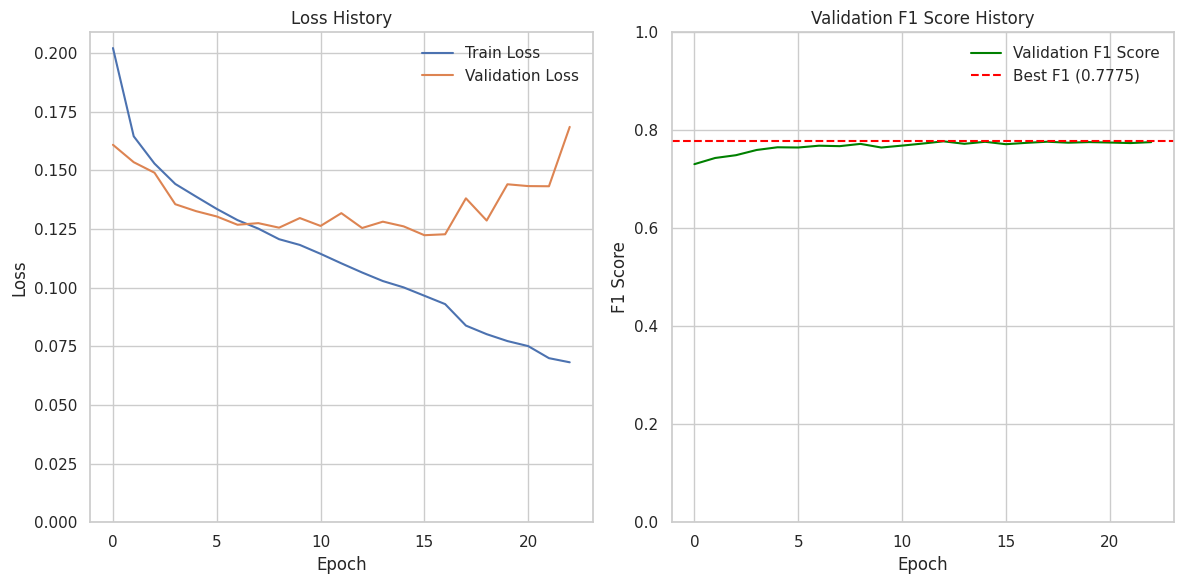

In [15]:
# --- Use the best_params dictionary from the Optuna study ---
print("\nTraining final model with best configuration found by Optuna...")
print("Best Params:", best_params)

# Make sure lstm_hidden_size is correctly handled if use_lstm is False
final_lstm_hidden_size = best_params.get('lstm_hidden_size', 256) if best_params['use_lstm'] else 256

final_model = DrumTranscriptionModel(
    n_mels=229,
    n_drums=N_DRUMS,
    use_lstm=best_params['use_lstm'],
    lstm_hidden_size=final_lstm_hidden_size, # Use best size
    dropout=best_params['dropout']           # Use best dropout
).to(device)

# Train with best config from Optuna study
# Use the full dataset loaders (train_loader, val_loader)
final_model, train_losses, val_losses, f1_scores = train_model(
    model=final_model,
    train_loader=train_loader,   # Use FULL train loader
    val_loader=val_loader,     # Use FULL val loader
    device=device,
    learning_rate=best_params['learning_rate'], # Use best LR
    epochs=50,  # Train for longer on the full dataset
    patience=10, # More patience for final model
    onset_weight=best_params['onset_weight'],    # Use best onset weight
    positive_weight=best_params['positive_weight'], # Use best positive weight
    accum_steps=4,  # Adjust based on memory for full training
    resume_from=None
)


## 7. Evaluate on Test Set

Evaluate the best model on the test set to get an unbiased measure of performance.

In [ ]:
# --- Evaluation on Test Set ---
# Load the BEST checkpoint saved during the *final* training run
best_final_model_path = MODEL_SAVE_DIR / 'drum_transcription_best.pt'
if best_final_model_path.exists():
    print(
        f"\nLoading best checkpoint from final training: {best_final_model_path}")
    checkpoint = torch.load(
        best_final_model_path,
        map_location=device,
        weights_only=False
    )

    # Re-create model instance with the SAME best_params used for final training
    eval_model = DrumTranscriptionModel(
        n_mels=229, n_drums=N_DRUMS,
        use_lstm=best_params['use_lstm'],
        lstm_hidden_size=final_lstm_hidden_size,
        dropout=best_params['dropout']
    ).to(device)
    eval_model.load_state_dict(checkpoint['model_state_dict'])
    eval_model.eval()

    print(
        f"Loaded best final model from epoch {checkpoint.get('epoch', 'N/A')+1}")

    # Evaluate on the test set using the SAME best_params
    print("Evaluating best final model on the test set...")
    test_metrics = validate(
        eval_model,
        test_loader,  # Use the main test_loader
        device,
        onset_weight=best_params['onset_weight'],
        positive_weight=best_params['positive_weight']
    )

    # Print detailed metrics
    print(
        f"\nTest Set Evaluation (Best Final Model, threshold={test_metrics['threshold']:.2f}):")
    print(
        f"Loss: {test_metrics['loss']:.4f} (Onset: {test_metrics['onset_loss']:.4f}, Velocity: {test_metrics['velocity_loss']:.4f})")
    print(
        f"F1 Score: {test_metrics['f1']:.4f}, Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}")


else:
    print(
        f"Could not find best model checkpoint at {best_final_model_path} from final training run.")


Loading best checkpoint from final training: ../models/drum_transcription_best.pt
Loaded best final model from epoch 13
Evaluating best final model on the test set...


Validating:   0%|          | 0/684 [00:00<?, ?it/s]

Optimizing threshold for Macro F1 score...
Optimal threshold found: 0.65 (yielding best Macro F1: 0.7723)
Calculating final metrics using threshold = 0.65

Test Set Evaluation (Best Final Model, threshold=0.65):
Loss: 0.1363 (Onset: 0.1590, Velocity: 0.0324)
F1 Score: 0.5599, Precision: 0.5790, Recall: 0.5420


## 8. Visualize Predictions

Let's visualize some predictions from the test set to qualitatively assess model performance.

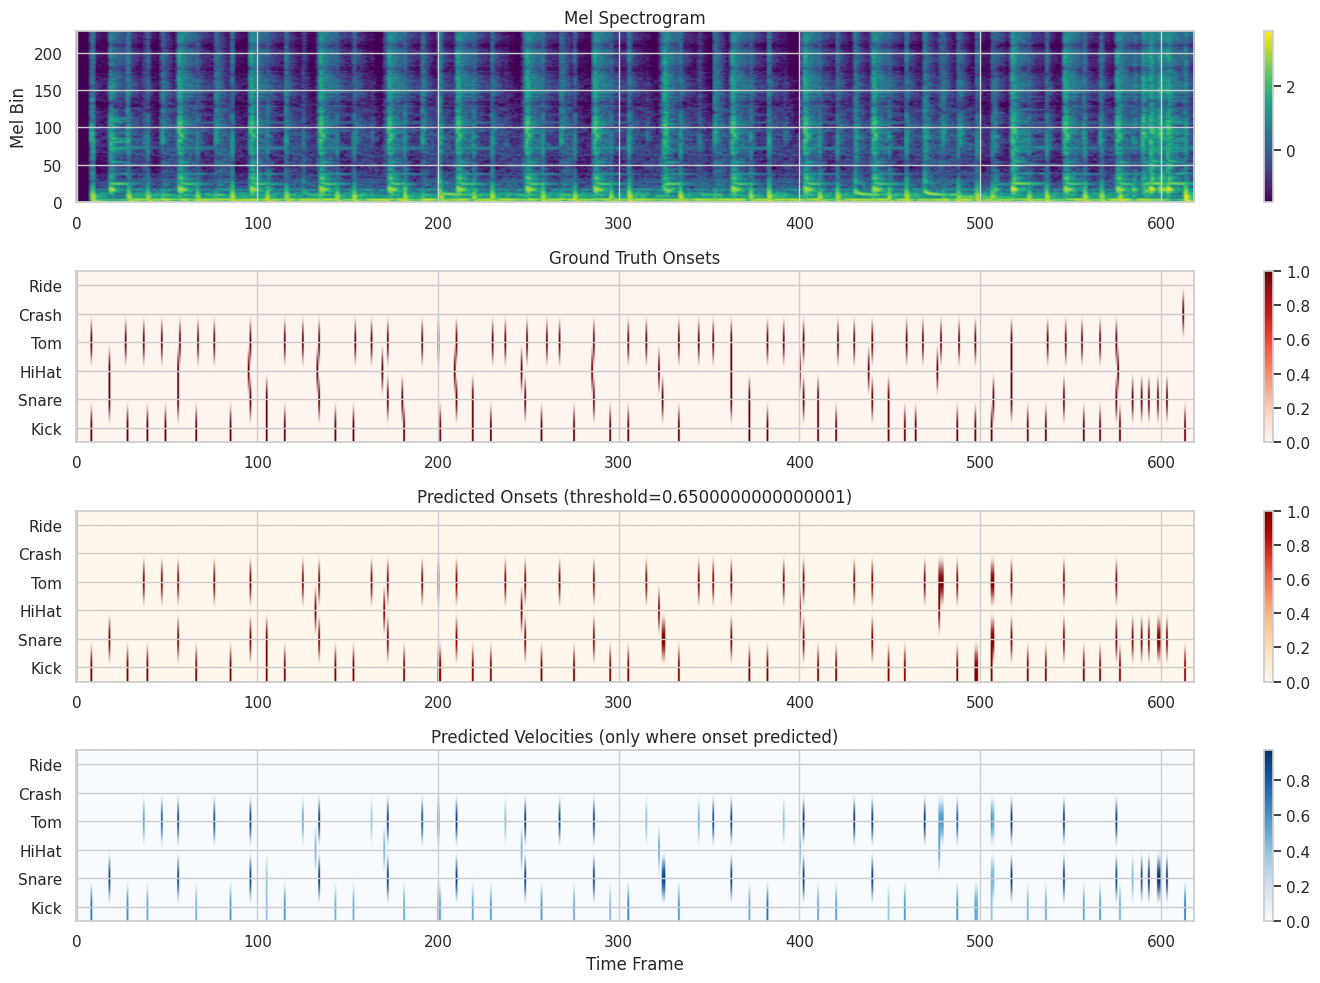

File: ../data/processed/test/drummer7_49_rock_135_beat_4-4_41.npz


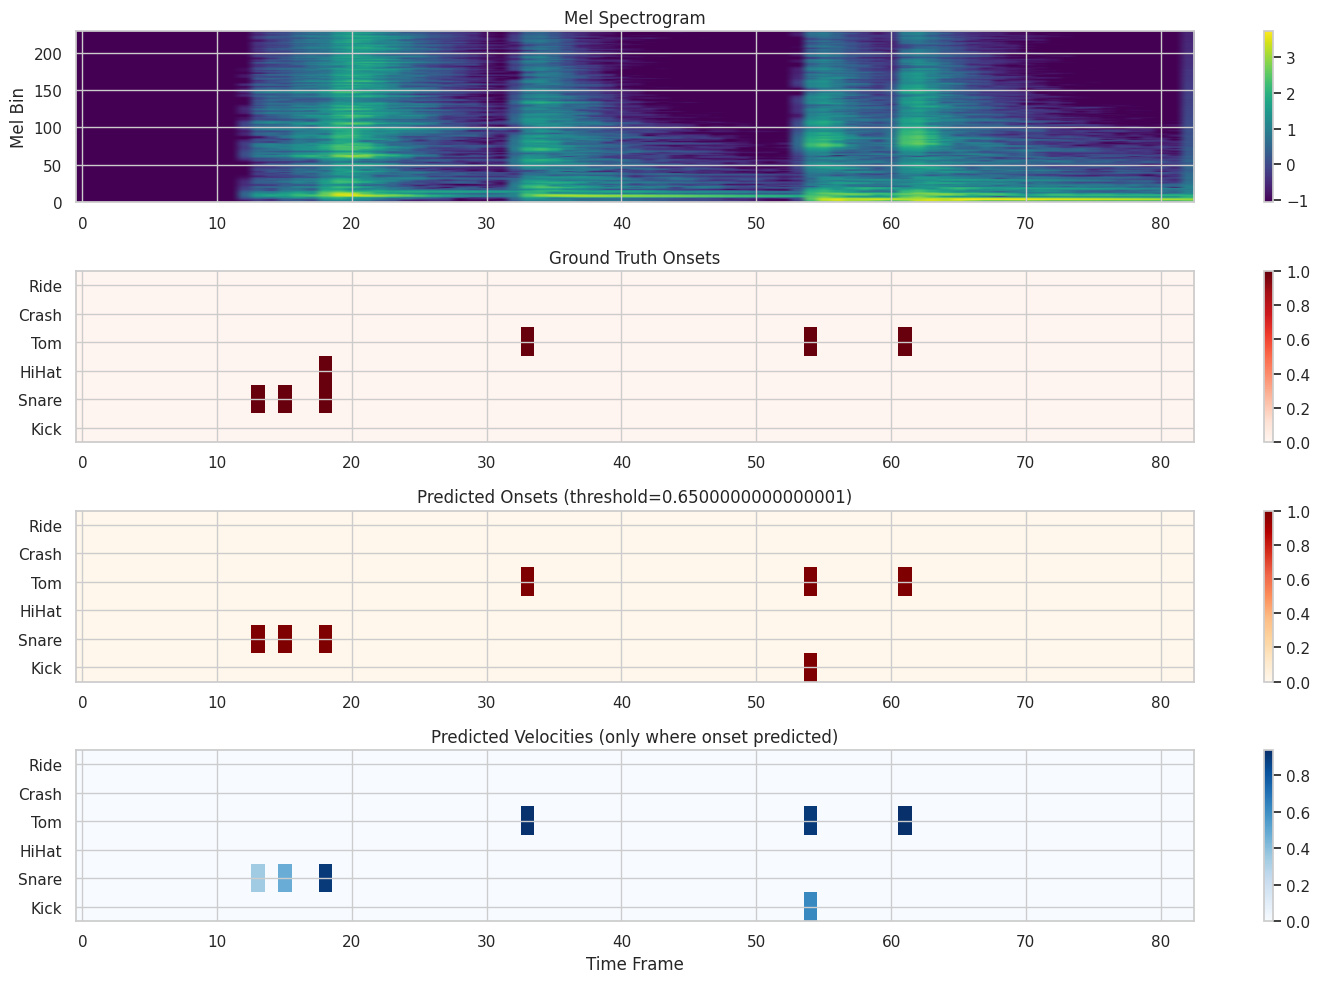

File: ../data/processed/test/drummer1_64_jazz_125_fill_4-4_33.npz


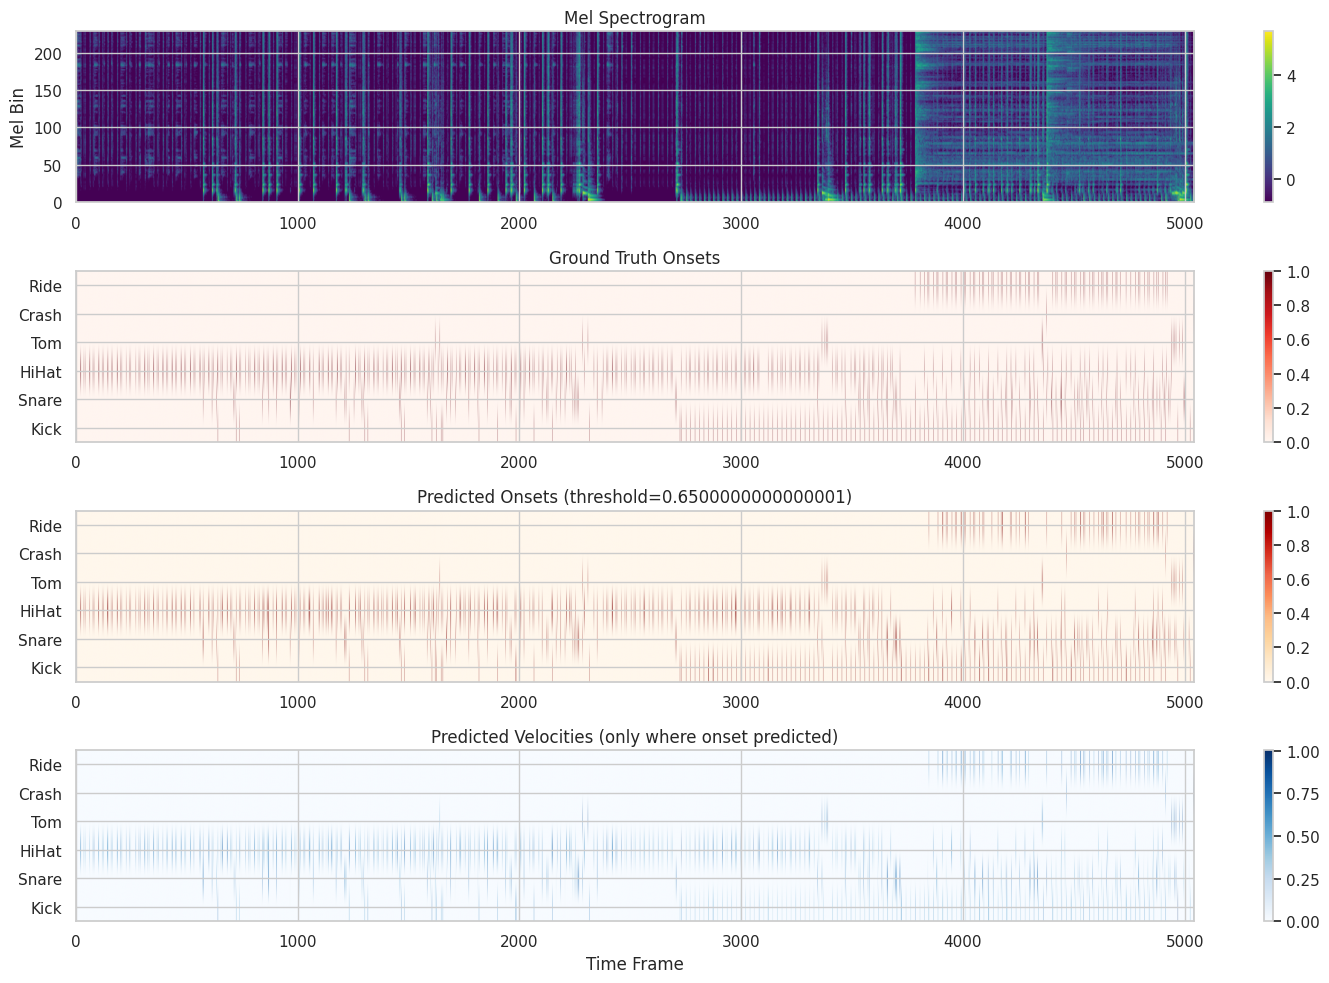

File: ../data/processed/test/drummer1_50_jazz_125_beat_4-4_21.npz


In [ ]:
# Visualize some predictions
if eval_model:
    visualize_predictions(
            eval_model, test_loader, device,
            threshold=test_metrics['threshold'], num_samples=3
    )